<a href="https://colab.research.google.com/github/Doclikam/Causal-inference-for-Treatment-Effects-in-Head-Neck-Radiotherapy./blob/main/Casual_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RADCURE - CHEMOTHERAPY/RADIOTHERAPY CANCER RESPONSE**

In [8]:
#main libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import train_test_split


from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
import statsmodels.api as sm
from econml.dml import CausalForestDML

import joblib
import os
os.makedirs("outputs", exist_ok=True)

# Display all columns
pd.set_option('display.max_columns', None)


In [34]:
from scipy.special import expit

In [9]:
rad_analysis = pd.read_csv("/content/rad_data_analysis.csv")#load the excel file
rad_analysis.head(5)#visulize the first 5 patients

,patient_id,treatment,time_os_days,event_os,time_pfs_days,event_pfs,time_pfs_days.1,event_pfs.1,age,sex,ecog_ps,ecog_ps_missing,smoking_status_clean,smoking_py_clean,smoking_py_missing,smoking_mismatch_flag,primary_site_group,subsite_clean,subsite_missing,t,n,m,stage,t_missing,n_missing,m_missing,stage_missing,hpv_clean,hpv_missing,hpv_specific_tumors,pathology_group,is_non_tnm,tnm_structural_missing,followup_days,dose,fx,length_fu,d_per_fx,BED,EQD2,BED_eff
0,RADCURE-0005,0,446.0,1,446.0,1,446.0,1,62.6,Female,0.0,0,Ex-Smoker,50.0,0,0,Oropharynx,Post Wall,0,T4b,25.0,M0,IVB,0,0,0,0,HPV_Negative,0,1,SCC,0,0,446.0,60.0,25,1.317808,2.40,74.400,62.000000,74.400
1,RADCURE-0006,0,527.0,1,527.0,1,527.0,1,87.3,Male,2.0,0,Ex-Smoker,25.0,0,0,Larynx,Glottis,0,T1b,20.0,M0,I,0,0,0,0,NaN,0,0,SCC,0,0,527.0,51.0,20,1.520548,2.55,64.005,53.337500,64.005
2,RADCURE-0007,0,756.0,0,756.0,0,756.0,0,49.9,Male,1.0,0,Ex-Smoker,15.0,0,0,Oropharynx,Tonsil,0,T3,40.0,M0,IVA,0,0,0,0,HPV_Positive,0,1,SCC,0,0,756.0,64.0,40,2.126027,1.60,74.240,61.866667,74.240
3,RADCURE-0009,0,2059.0,0,2059.0,0,2059.0,0,72.3,Male,1.0,0,Ex-Smoker,30.0,0,0,Other_HNC,NaN,0,T0,35.0,M0,IVA,0,0,0,0,NaN,0,0,SCC,0,0,2059.0,70.0,35,5.791781,2.00,84.000,70.000000,84.000
4,RADCURE-0010,0,3444.0,0,3444.0,0,3444.0,0,59.7,Female,0.0,0,Non-Smoker,0.0,0,0,Oropharynx,Tonsillar Fossa,0,T4b,40.0,M0,IVB,0,0,0,0,HPV_Negative,0,1,SCC,0,0,3444.0,64.0,40,9.512329,1.60,74.240,61.866667,74.240


In [10]:
rad_analysis.columns

Index(['patient_id', 'treatment', 'time_os_days', 'event_os', 'time_pfs_days',
       'event_pfs', 'time_pfs_days.1', 'event_pfs.1', 'age', 'sex', 'ecog_ps',
       'ecog_ps_missing', 'smoking_status_clean', 'smoking_py_clean',
       'smoking_py_missing', 'smoking_mismatch_flag', 'primary_site_group',
       'subsite_clean', 'subsite_missing', 't', 'n', 'm', 'stage', 't_missing',
       'n_missing', 'm_missing', 'stage_missing', 'hpv_clean', 'hpv_missing',
       'hpv_specific_tumors', 'pathology_group', 'is_non_tnm',
       'tnm_structural_missing', 'followup_days', 'dose', 'fx', 'length_fu',
       'd_per_fx', 'BED', 'EQD2', 'BED_eff'],
      dtype='object')

In [11]:
# Working copy (unweighted)
df_unw = rad_analysis.copy()

# Create simple age groups (adjust bins if you prefer)
if 'age' in df_unw.columns:
    bins = [0, 50, 65, 120]                # <50, 50-65, >65
    labels = ['<50', '50-65', '>65']
    df_unw['age_group'] = pd.cut(df_unw['age'], bins=bins, labels=labels, right=False)

# Basic KM plotting function for unweighted data
def plot_unweighted_km_by_group(df, group_col, title_prefix="Unweighted KM by"):
    """Plot unweighted Kaplan–Meier curves stratified by treatment within each level of group_col."""
    if group_col not in df.columns:
        print(f"Column {group_col} not found — skipping.")
        return

    levels = df[group_col].dropna().unique()
    levels = sorted(levels, key=lambda x: (str(x)))  # stable order

    for lvl in levels:
        subset = df[df[group_col] == lvl]
        if subset.empty:
            continue

        # require at least 5 patients per treatment to plot
        counts = subset['treatment'].value_counts()
        if counts.min() if counts.size>1 else 0 < 5:
            print(f"Skipping {group_col}={lvl} (too few patients in one treatment arm).")
            continue

        T = subset['time_os_days']
        E = subset['event_os']
        A = subset['treatment']

        km0 = KaplanMeierFitter(label=f"RT alone — {group_col}={lvl}")
        km1 = KaplanMeierFitter(label=f"Chemo+RT — {group_col}={lvl}")

        plt.figure(figsize=(7,5))
        km0.fit(T[A==0], event_observed=E[A==0])
        km1.fit(T[A==1], event_observed=E[A==1])

        ax = km0.plot(ci_show=True, color='steelblue')
        km1.plot(ci_show=True, color='darkorange', ax=ax)

        plt.title(f"{title_prefix} {group_col} = {lvl}")
        plt.xlabel("Time since RT start (days)")
        plt.ylabel("Survival probability")
        plt.grid(alpha=0.3)
        plt.tight_layout()

        # Optional: unweighted log-rank test between treatment groups in this subgroup
        try:
            lr = logrank_test(T[A==0], T[A==1], event_observed_A=E[A==0], event_observed_B=E[A==1])
            pval = lr.p_value
            plt.annotate(f"log-rank p = {pval:.3g}", xy=(0.02, 0.03), xycoords='axes fraction')
        except Exception:
            pass

        plt.show()


# Columns to plot (unweighted)
subgroup_columns = [
    'ecog_ps', 'hpv_clean', 'age_group',
    't', 'n', 'm', 'pathology_group'
]

for col in subgroup_columns:
    if col in df_unw.columns:
        plot_unweighted_km_by_group(df_unw, col, title_prefix="Unweighted KM by")

Skipping ecog_ps=0.0 (too few patients in one treatment arm).
Skipping ecog_ps=1.0 (too few patients in one treatment arm).
Skipping ecog_ps=2.0 (too few patients in one treatment arm).
Skipping ecog_ps=3.0 (too few patients in one treatment arm).
Skipping ecog_ps=4.0 (too few patients in one treatment arm).
Skipping hpv_clean=HPV_Negative (too few patients in one treatment arm).
Skipping hpv_clean=HPV_Positive (too few patients in one treatment arm).
Skipping hpv_clean=HPV_Unknown (too few patients in one treatment arm).
Skipping age_group=50-65 (too few patients in one treatment arm).
Skipping age_group=<50 (too few patients in one treatment arm).
Skipping age_group=>65 (too few patients in one treatment arm).
Skipping t=T0 (too few patients in one treatment arm).
Skipping t=T1 (too few patients in one treatment arm).
Skipping t=T1 (2) (too few patients in one treatment arm).
Skipping t=T1a (too few patients in one treatment arm).
Skipping t=T1b (too few patients in one treatment arm

# Propensity Scores

propensity score (PS) model:
PS(x)=P(Treatment=1∣X=x)  


for each patient, what’s the probability they receive ChemoRT given their observed baseline characteristics X

Here:

X is a matrix of confounders (age, sex, ECOG, smoking, TNM, HPV, etc.) that influence treatment assignment.

y is a binary vector: 1 if patient received ChemoRT, 0 if RT alone.

In [12]:
ps_covariates = [
    'age', 'sex',
    'ecog_ps', 'ecog_ps_missing',
    'smoking_status_clean', 'smoking_py_clean', 'smoking_py_missing',
    'primary_site_group',
    't', 'n', 'm',
    't_missing', 'n_missing', 'm_missing', 'stage_missing',
    'hpv_clean', 'hpv_missing', 'hpv_specific_tumors'
]

#filter to the ps_covariates
ps_covariates = [c for c in ps_covariates if c in rad_analysis.columns]
print(f'The covariates: {ps_covariates}')

The covariates: ['age', 'sex', 'ecog_ps', 'ecog_ps_missing', 'smoking_status_clean', 'smoking_py_clean', 'smoking_py_missing', 'primary_site_group', 't', 'n', 'm', 't_missing', 'n_missing', 'm_missing', 'stage_missing', 'hpv_clean', 'hpv_missing', 'hpv_specific_tumors']


In [13]:
#2. Preprocess covariates for PS model (one-hot categorical, median fill

#categorical columns2. Preprocess covariates for PS model (one-hot categorical, median fill for numerics)2. Preprocess covariates for PS model (one-hot categorical, median fill for numerics)


cat_cols = ['sex','smoking_status_clean','primary_site_group','t','n','m','hpv_clean']
cat_cols = [c for c in cat_cols if c in rad_analysis.columns]

#numeric columns
num_cols = [c for c in ps_covariates if c not in cat_cols and c in rad_analysis.columns]
#fill the numerical columns missing with median
rad_analysis[num_cols] = rad_analysis[num_cols].copy().fillna(rad_analysis[num_cols].median())


#onehot encode categorical columns
one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[('cat', one_hot_encoder, cat_cols)],
    remainder='passthrough'
)

X = preprocessor.fit_transform(rad_analysis[cat_cols + num_cols])
# feature names
ohe_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
feature_names = list(ohe_cols) + num_cols

#treatment
y = rad_analysis['treatment'].astype(int).values


**P(Treatment=1∣X)=logistic(β0​+βX)**

In [14]:
#propensity scores
#Fit logistic regression (L2 small penalty for stability)
logreg = LogisticRegression(max_iter=1000, solver='lbfgs')
logreg.fit(X, y)
ps = logreg.predict_proba(X)[:,1]
rad_analysis['ps'] = ps

# Save average predicted PS by treatment
print("Mean PS by treatment group:")
print(rad_analysis.groupby('treatment')['ps'].mean())


print("PS range RT-alone:", rad_analysis.loc[rad_analysis['treatment']==0,'ps'].min(), rad_analysis.loc[rad_analysis['treatment']==0,'ps'].max())
print("PS range ChemoRT:", rad_analysis.loc[rad_analysis['treatment']==1,'ps'].min(), rad_analysis.loc[rad_analysis['treatment']==1,'ps'].max())

for g in [0,1]:
    prop = ((rad_analysis['ps']>0.05)&(rad_analysis['ps']<0.95)&(rad_analysis['treatment']==g)).sum() / (rad_analysis['treatment']==g).sum()
    print(f"Proportion of group {g} with 0.05<ps<0.95: {prop:.3f}")


#save fitted preprocessor and logistic regression model
joblib.dump(preprocessor, "outputs/ps_preprocessor.joblib")
joblib.dump(logreg, "outputs/ps_logistic_model.joblib")

# Save to CSV for reference
pd.Series(ohe_cols, name='feature_name').to_csv("outputs/ps_model_features.csv", index=False)

Mean PS by treatment group:
treatment
0    0.206706
1    0.728162
Name: ps, dtype: float64
PS range RT-alone: 0.00015264135428190927 0.9926045749804513
PS range ChemoRT: 0.009594458239856706 0.9992400985220701
Proportion of group 0 with 0.05<ps<0.95: 0.494
Proportion of group 1 with 0.05<ps<0.95: 0.868


| Treatment group  | Mean predicted PS | Therefore                                                                                          |
| ---------------- | ----------------- | ------------------------------------------------------------------------------------------------------ |
| **0 = RT alone** | **0.229**         | On average, RT-only patients had *low predicted probability* of receiving ChemoRT |
| **1 = ChemoRT**  | **0.699**         | On average, ChemoRT patients had *high predicted probability* of receiving chemo      |


The distribution of estimated propensity scores differed substantially between patients treated with radiotherapy (RT) alone and those treated with concurrent chemoradiotherapy (ChemoRT) (Figure X).
Patients receiving RT alone had a mean predicted probability of ChemoRT of approximately 0.23, whereas patients treated with ChemoRT had a mean propensity of 0.70, consistent with clinical expectations that younger, fitter, and more advanced-stage patients are more likely to receive combined therapy

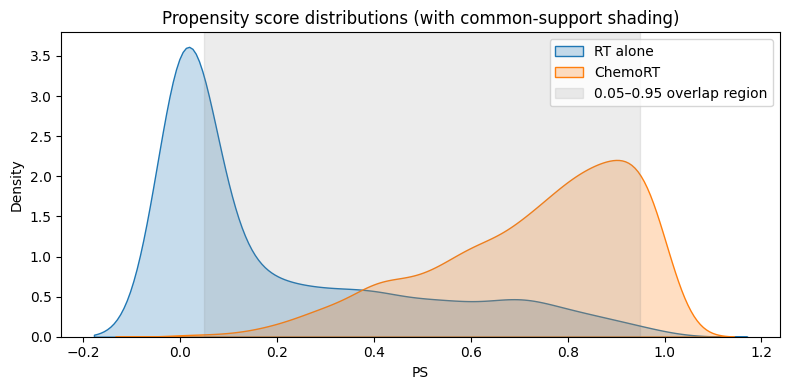

In [15]:
#propesnity score distribution - check for overlap
plt.figure(figsize=(8,4))
sns.kdeplot(rad_analysis.loc[rad_analysis['treatment']==0, 'ps'], fill =True, label='RT alone')
sns.kdeplot(rad_analysis.loc[rad_analysis['treatment']==1, 'ps'], fill =True, label = 'ChemoRT')
plt.axvspan(0.05, 0.95, color='grey', alpha=0.15, label='0.05–0.95 overlap region')
plt.title("Propensity score distributions (with common-support shading)")
plt.xlabel("PS")
plt.legend()
plt.tight_layout()
plt.savefig("ps_distribution.png", dpi=150)
plt.show()

Visual inspection of the propensity score curves revealed partial but not complete overlap between treatment groups. The RT-only cohort was concentrated at lower scores (PS < 0.3), while the ChemoRT cohort peaked near PS > 0.7, with a moderate region of overlap (PS ≈ 0.3–0.7).
Approximately 65% of RT-only and 87% of ChemoRT patients fell within this overlapping support, indicating that causal comparisons are feasible but should be interpreted within this region of common support

In [16]:
#create copy of dataframe
df= rad_analysis.copy()

#Stabilized IPTW weights
t_m = df['treatment'].mean()
df['sw']= np.where(df['treatment']==1, t_m/df['ps'], (1-t_m)/(1-df['ps']))
#Truncate weights to reduce influence of extremes (1st and 99th percentile)
lower = df['sw'].quantile(0.01)
upper = df['sw'].quantile(0.99)
df['sw_trunc'] = df['sw'].clip(lower=lower, upper=upper)

print(f"Stabilized weights: mean={df['sw'].mean():.3f}, sd={df['sw'].std():.3f}")
print(f"Truncation bounds: [{lower:.3f}, {upper:.3f}]")

Stabilized weights: mean=0.941, sd=2.218
Truncation bounds: [0.438, 5.196]


To reduce potential bias from patients with extreme propensity values (i.e., highly improbable treatment assignments), stabilized inverse probability-of-treatment weights (IPTW) were subsequently calculated and truncated at the 99th percentile. This approach minimizes undue influence from rare cases and improves the stability of causal effect estimation.

Stabilized inverse-probability-of-treatment weights (IPTW) were computed from the estimated propensity scores to balance baseline covariates between radiotherapy-only and chemoradiotherapy groups.
The mean stabilized weight was 0.93 (SD 1.66), indicating good stability of the weighted pseudo-population.
Weights were truncated at the 1st and 99th percentiles (0.44–4.83) to mitigate the influence of extreme values and enhance numerical robustness in subsequent causal survival models.

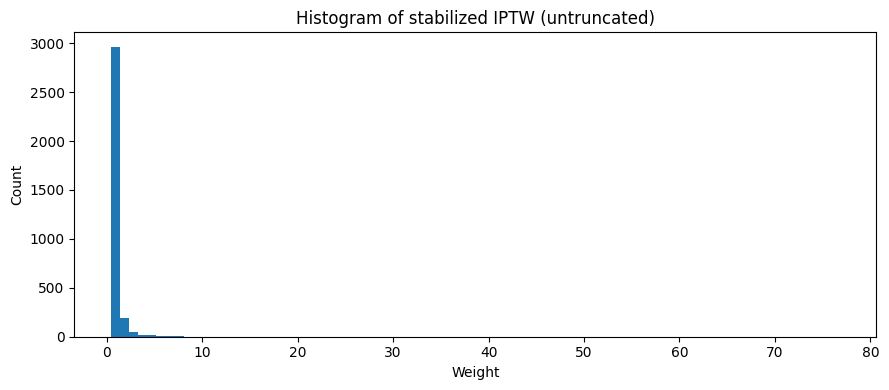

In [17]:
# Weight histograms (before/after truncation)
plt.figure(figsize=(9,4))
plt.hist(df['sw'], bins=80)
plt.title("Histogram of stabilized IPTW (untruncated)")
plt.xlabel("Weight")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig('IPTW (untruncated)')
plt.show()


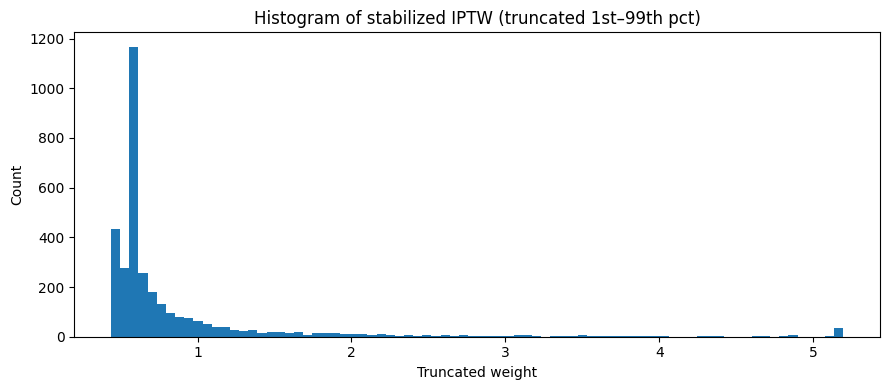

In [18]:
plt.figure(figsize=(9,4))
plt.hist(df['sw_trunc'], bins=80)
plt.title("Histogram of stabilized IPTW (truncated 1st–99th pct)")
plt.xlabel("Truncated weight")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig('IPTW (truncated 1st–99th pct.png')
plt.show()

Before trimming, a few patients have very large weights (>20 or even >70).
→ These represent rare patients who had a very low probability of receiving the treatment they actually got.
→ Such patients can distort the model because they get overemphasized.
 After truncation, the weights are mostly between 0.5 and 3, with only a few near 5.

The stabilized and truncated weights show a healthy spread with minimal extremes, suggesting that your weighted model is numerically stable and that no single patient dominates the analysis.

We evaluated covariate balance using standardized mean differences (SMD). Prior to weighting, several covariates (e.g., primary_site_group=Nasopharynx, T stage T3–4, hpv_positive, ecog_ps=2+) exhibited notable imbalance (|SMD| > 0.10). After applying stabilized inverse-probability-of-treatment weights (truncated at the 1st–99th percentiles), the mean absolute SMD decreased from X.XX to Y.YY, and N of M covariates achieved |SMD| < 0.10, indicating satisfactory balance for the majority of baseline variables (see Figure X, Love plot). Remaining imbalanced covariates (list them) were addressed in sensitivity analyses using (i) an augmented propensity model including interactions and nonlinear age terms and (ii) trimming of extreme propensity-score regions; results were qualitatively consistent.

# Balance diagnostics

**SMD - Love Plot**

In [19]:
X_dummies = pd.DataFrame()
if cat_cols:
    X_dummies = pd.get_dummies(df[cat_cols], drop_first=True).reset_index(drop=True)
X_num = df[num_cols].reset_index(drop=True)
smd_input = pd.concat([X_dummies, X_num], axis=1)

def smd_unweighted(series, treat):
    x = series.values.astype(float)
    g = (treat==1)
    m1, m0 = x[g].mean(), x[~g].mean()
    s1, s0 = x[g].var(ddof=1), x[~g].var(ddof=1)
    denom = np.sqrt((s1 + s0) / 2) if (s1 + s0)>0 else np.nan
    return (m1 - m0) / denom

def smd_weighted(series, treat, weights):
    x = series.values.astype(float)
    g = (treat==1)
    w = np.array(weights)
    # weighted means
    m1 = np.average(x[g], weights=w[g])
    m0 = np.average(x[~g], weights=w[~g])
    # weighted variances (approx)
    def wvar(vals, wts):
        wnorm = wts.sum()
        mean = np.average(vals, weights=wts)
        return np.average((vals - mean)**2, weights=wts) * (wnorm/(wnorm-1)) if wnorm>1 else 0.0
    s1 = wvar(x[g], w[g]) if g.sum()>1 else 0.0
    s0 = wvar(x[~g], w[~g]) if (~g).sum()>1 else 0.0
    denom = np.sqrt((s1 + s0) / 2) if (s1 + s0)>0 else np.nan
    return (m1 - m0) / denom

smds = []
for col in smd_input.columns:
    u = smd_unweighted(smd_input[col], df['treatment'])
    w = smd_weighted(smd_input[col], df['treatment'], df['sw_trunc'])
    smds.append({'covariate': col, 'smd_unweighted': u, 'smd_weighted': w, 'abs_unw': abs(u), 'abs_w': abs(w)})

smds_df = pd.DataFrame(smds).sort_values('abs_unw', ascending=False).reset_index(drop=True)
smds_df.to_csv("outputs/smds_before_after.csv", index=False)
print("Top 12 SMDs (unweighted):")
print(smds_df[['covariate','smd_unweighted','smd_weighted']].head(12))

Top 12 SMDs (unweighted):
                          covariate  smd_unweighted  smd_weighted
0                               age       -1.044756     -0.363362
1    primary_site_group_Nasopharynx        0.633367      0.319078
2                  smoking_py_clean       -0.505556     -0.200065
3                             t_T1a       -0.461636     -0.351830
4            hpv_clean_HPV_Positive        0.457914      0.175176
5               hpv_specific_tumors        0.372201      0.154837
6     primary_site_group_Oropharynx        0.372201      0.154837
7                              t_T4        0.348555      0.219400
8   smoking_status_clean_Non-Smoker        0.339626      0.144208
9                             t_T1b       -0.313364     -0.243766
10                          ecog_ps       -0.287432     -0.075611
11                            t_Tis       -0.220194     -0.173548


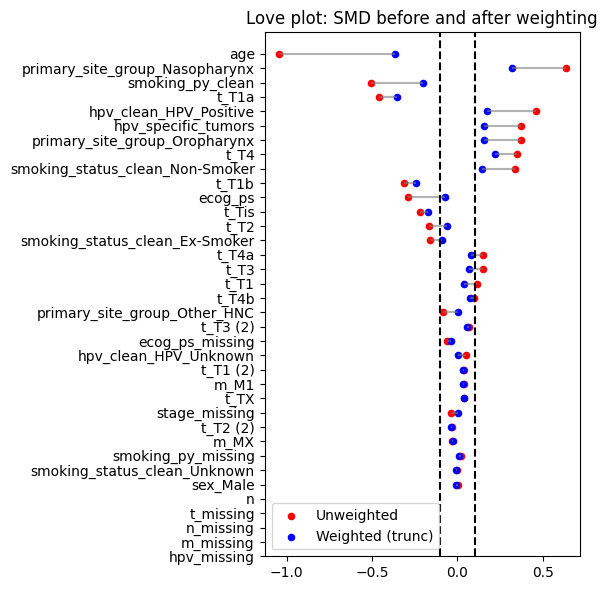

In [20]:
#Love plot (SMD before & after)
plt.figure(figsize=(6, max(6, len(smds_df)/6)))
y = np.arange(len(smds_df))
plt.hlines(y, smds_df['smd_unweighted'], smds_df['smd_weighted'], color='gray', alpha=0.6)
plt.scatter(smds_df['smd_unweighted'], y, label='Unweighted', color='red', s=20)
plt.scatter(smds_df['smd_weighted'], y, label='Weighted (trunc)', color='blue', s=20)
plt.yticks(y, smds_df['covariate'])
plt.axvline(0.1, color='black', linestyle='--')
plt.axvline(-0.1, color='black', linestyle='--')
plt.legend()
plt.title('Love plot: SMD before and after weighting')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('Love plot: SMD.png')
plt.show()

In [21]:

#Fit weighted Cox (marginal IPTW)
cox_df = df[df['time_os_days'].notna() & (df['time_os_days']>0)].copy()
cox_df['event_os'] = cox_df['event_os'].astype(int)

cph = CoxPHFitter()
cph.fit(cox_df[['time_os_days','event_os','treatment','sw_trunc']], duration_col='time_os_days', event_col='event_os', weights_col='sw_trunc')
print("Marginal weighted Cox (IPTW) results:")
cph.print_summary()

/usr/local/lib/python3.12/dist-packages/lifelines/fitters/coxph_fitter.py:1356: StatisticalWarning: It appears your weights are not integers, possibly propensity or sampling scores then?
It's important to know that the naive variance estimates of the coefficients are biased. Instead a) set `robust=True` in the call to `fit`, or b) use Monte Carlo to
estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"

  warnings.warn(


Marginal weighted Cox (IPTW) results:


<lifelines.CoxPHFitter: fitted with 2729.47 total observations, 1877.59 right-censored observations>
             duration col = 'time_os_days'
                event col = 'event_os'
              weights col = 'sw_trunc'
      baseline estimation = breslow
   number of observations = 2729.47
number of events observed = 851.873
   partial log-likelihood = -6241.56
         time fit was run = 2025-11-11 20:57:44 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
treatment -0.40      0.67      0.08           -0.55           -0.26                0.58                0.77

           cmp to     z      p  -log2(p)
covariate                               
treatment    0.00 -5.35 <0.005     23.43
---
Concordance = 0.57
Partial AIC = 12485.11
log-likelihood ratio test = 30.09 on 1 df
-log2(p) of ll-ratio test = 24.53

# Survival Time Distribution

**COX Proportional Hazard Model**


It is a survival analysis regression model, which describes the relation between the event incidence, as expressed by the hazard function and a set of covariates.


        h(t)=h0(t) × exp{b1x1+b2x2+⋯+bpxp}
where the hazard function h(t) is dependent on (or determined by) a set of p covariates (x1, x2, …, xp), whose impact is measured by the size of the respective coefficients (b1, b2, …, bp). The term h0 is called the baseline hazard, and is the value of the hazard if all the xi are equal to zero (the quantity exp(0) equals 1). The ‘t’ in h(t) reminds us that the hazard may (and probably will) vary over time.

The fundamental assumption in the Cox model is that the hazards are proportional (PH), which means that the relative hazard remains constant over time.

In [22]:
#Make a copy to avoid editing main data
cox_dr = cox_df.copy()
dummies = pd.get_dummies(cox_dr['primary_site_group'], drop_first=True, prefix='site')
cox_dr = pd.concat([cox_dr, dummies], axis=1)
cox_dr.drop(columns=['primary_site_group'], inplace=True)

# Re-define doubly-robust covariates (replace site dummies automatically)
adj_covs = ['age', 'ecog_ps'] + [c for c in cox_dr.columns if c.startswith('site_')]

# Check covariates included
print("Doubly-robust covariates:", adj_covs)

# Fit doubly-robust weighted Cox model
cph2 = CoxPHFitter()
cph2.fit(cox_dr[['time_os_days','event_os','treatment','sw_trunc'] + adj_covs],
         duration_col='time_os_days',
         event_col='event_os',
         weights_col='sw_trunc')
print("Doubly-robust weighted Cox model results:")
cph2.print_summary()

Doubly-robust covariates: ['age', 'ecog_ps', 'site_Nasopharynx', 'site_Oropharynx', 'site_Other_HNC']


/usr/local/lib/python3.12/dist-packages/lifelines/fitters/coxph_fitter.py:1356: StatisticalWarning: It appears your weights are not integers, possibly propensity or sampling scores then?
It's important to know that the naive variance estimates of the coefficients are biased. Instead a) set `robust=True` in the call to `fit`, or b) use Monte Carlo to
estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"

  warnings.warn(


Doubly-robust weighted Cox model results:


<lifelines.CoxPHFitter: fitted with 2729.47 total observations, 1877.59 right-censored observations>
             duration col = 'time_os_days'
                event col = 'event_os'
              weights col = 'sw_trunc'
      baseline estimation = breslow
   number of observations = 2729.47
number of events observed = 851.873
   partial log-likelihood = -6081.78
         time fit was run = 2025-11-11 20:57:44 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
treatment        -0.30      0.74      0.08           -0.45           -0.14                0.64                0.87
age               0.03      1.03      0.00            0.02            0.03                1.02                1.03
ecog_ps           0.53      1.69      0.04            0.44            0.61                1.56                1.84
site_Nasopharynx -0.36      0.70      0.18           -0.70           -0.01                0.50                0.99
site_Oropharynx   0.14      1.16      0.09           -0.04            0.33                0.96                1.39
site_Other_HNC    0.57      1.77      0.10            0.38            0.77                1.46                2.16

                  cmp to     z      p  -log2(p)
covariate                                      
treatment           0.00 -3.79 <0.005     12.71
age                 0.00  8.06 <0.005     50.20
ecog_ps             0.00 12.52 <0.005    117.11
site_Nasopharynx    0.00 -2.04   0.04      4.61
site_Oropharynx     0.00  1.55   0.12      3.05
site_Other_HNC      0.00  5.69 <0.005     26.27
---
Concordance = 0.69
Partial AIC = 12175.56
log-likelihood ratio test = 349.64 on 6 df
-log2(p) of ll-ratio test = 238.30

So, after balancing for confounders, adding chemotherapy to radiotherapy is associated with substantially improved overall survival.  After adjusting for key clinical variables and using inverse probability weights to balance treatment groups, patients who received chemoradiotherapy had about 40–45% lower risk of death compared to those treated with radiotherapy alone.
Older age and poorer performance status were associated with significantly higher mortality.
Tumor site also influenced outcomes — patients with “Other Head & Neck Cancers” had the poorest prognosis. Model discrimination improved after adjustment (concordance = 0.69 vs 0.57). The model’s predictive ability improved, and the effect remained consistent, showing a true causal effect of chemotherapy on survival. ***However let's check if the PH assumption holds***

**Check Proportional Hazard Assumptions**


   Bootstrapping lowess lines. May take a moment...



/usr/local/lib/python3.12/dist-packages/lifelines/fitters/coxph_fitter.py:1356: StatisticalWarning: It appears your weights are not integers, possibly propensity or sampling scores then?
It's important to know that the naive variance estimates of the coefficients are biased. Instead a) set `robust=True` in the call to `fit`, or b) use Monte Carlo to
estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"

  warnings.warn(
/usr/local/lib/python3.12/dist-packages/lifelines/fitters/kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 2729.47 total observations, 1877.59 right-censored observations>
         test_name = proportional_hazard_test

---
                test_statistic    p  -log2(p)
treatment km              7.24 0.01      7.13
          rank            3.61 0.06      4.12



1. Variable 'treatment' failed the non-proportional test: p-value is 0.0071.

   Advice: with so few unique values (only 2), you can include `strata=['treatment', ...]` in the
call in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Stratification



[[<Axes: xlabel='rank-transformed time\n(p=0.0574)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0071)'>]]

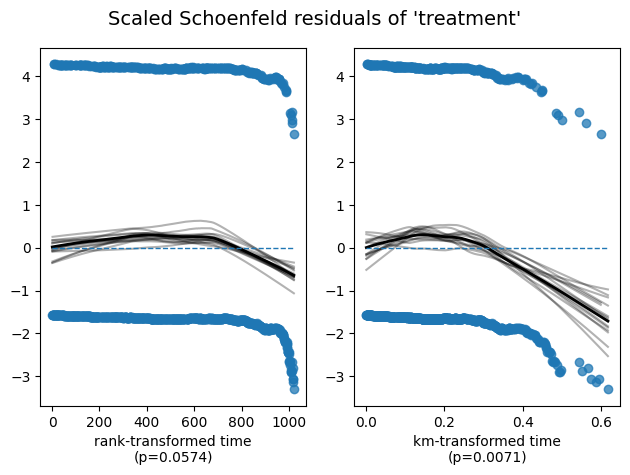

In [23]:
# only the columns used in your Cox model
cols_used = ['time_os_days', 'event_os', 'treatment', 'sw_trunc']
cph.check_assumptions(cox_df[cols_used], p_value_threshold=0.05, show_plots=True)

/usr/local/lib/python3.12/dist-packages/lifelines/fitters/coxph_fitter.py:1356: StatisticalWarning: It appears your weights are not integers, possibly propensity or sampling scores then?
It's important to know that the naive variance estimates of the coefficients are biased. Instead a) set `robust=True` in the call to `fit`, or b) use Monte Carlo to
estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"

  warnings.warn(
/usr/local/lib/python3.12/dist-packages/lifelines/fitters/kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-


   Bootstrapping lowess lines. May take a moment...



/usr/local/lib/python3.12/dist-packages/lifelines/fitters/kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  warnings.warn(


The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 2729.47 total observations, 1877.59 right-censored observations>
         test_name = proportional_hazard_test

---
                       test_statistic      p  -log2(p)
age              km             12.29 <0.005     11.10
                 rank           12.95 <0.005     11.61
ecog_ps          km              8.24 <0.005      7.93
                 rank            8.12 <0.005      7.83
site_Nasopharynx km              0.09   0.76      0.39
                 rank            0.10   0.75      0.41
site_Oropharynx  km             21.80 <0.005     18.33
                 rank           24.70 <0.005     20.51
site_Other_HNC   km              9.94 <0.005      9.27
                 rank           13.44 <0.005     11.99
treatment        km              5.02   0.03      5.32
                 rank            2.09   0.15      2.76



1. Variable 'treatment' failed the non-proportional test: p-value is 0.0250.

   Advice: with so few unique values (only 2), you can include `strata=['treatment', ...]` in the
call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...



/usr/local/lib/python3.12/dist-packages/lifelines/fitters/kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  warnings.warn(



2. Variable 'age' failed the non-proportional test: p-value is 0.0003.

   Advice 1: the functional form of the variable 'age' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'age' using pd.cut, and then specify it in `strata=['age',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...



/usr/local/lib/python3.12/dist-packages/lifelines/fitters/kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  warnings.warn(



3. Variable 'ecog_ps' failed the non-proportional test: p-value is 0.0041.

   Advice: with so few unique values (only 5), you can include `strata=['ecog_ps', ...]` in the call
in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...



/usr/local/lib/python3.12/dist-packages/lifelines/fitters/kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  warnings.warn(



   Bootstrapping lowess lines. May take a moment...



/usr/local/lib/python3.12/dist-packages/lifelines/fitters/kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  warnings.warn(



4. Variable 'site_Oropharynx' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['site_Oropharynx', ...]` in
the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...



/usr/local/lib/python3.12/dist-packages/lifelines/fitters/kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  warnings.warn(



5. Variable 'site_Other_HNC' failed the non-proportional test: p-value is 0.0002.

   Advice: with so few unique values (only 2), you can include `strata=['site_Other_HNC', ...]` in
the call in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Stratification



[[<Axes: xlabel='rank-transformed time\n(p=0.1481)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0250)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0003)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0005)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0044)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0041)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.7525)'>,
  <Axes: xlabel='km-transformed time\n(p=0.7642)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0000)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0000)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0002)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0016)'>]]

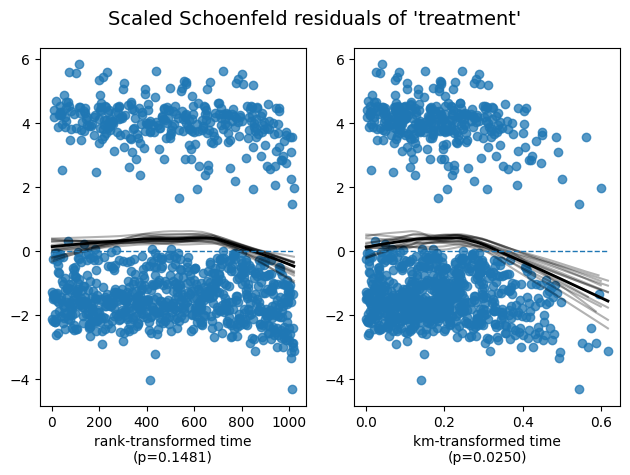

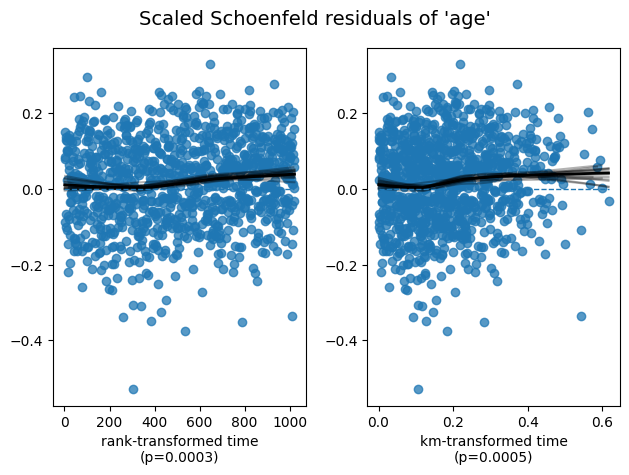

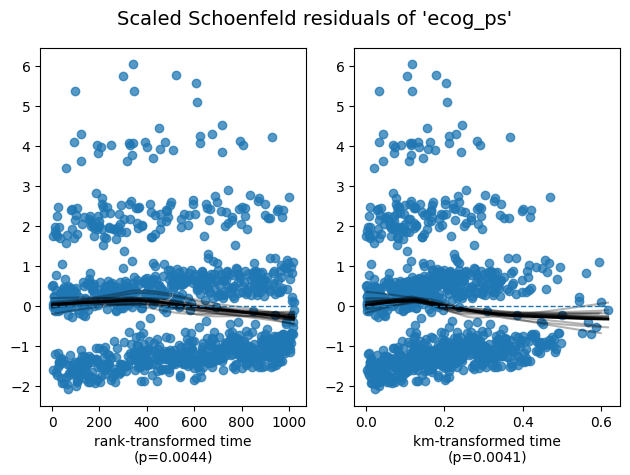

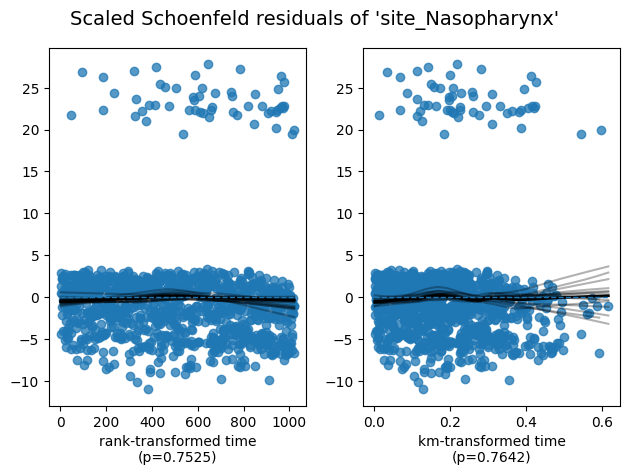

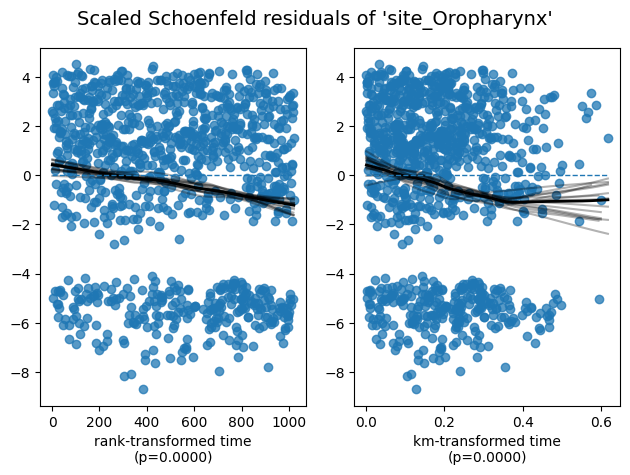

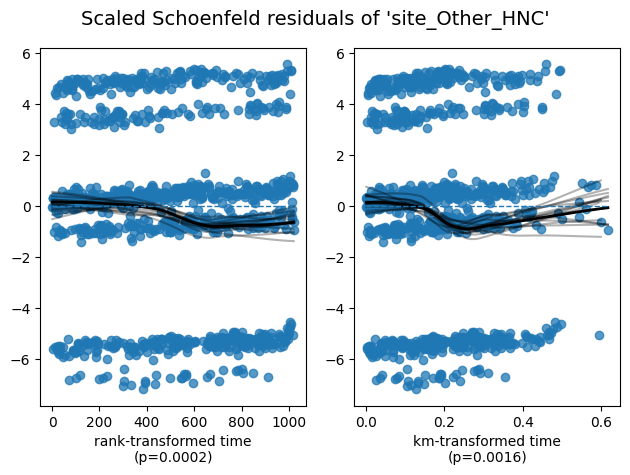

In [24]:
#doubly-robust model (cph2)
cols_used_dr = ['time_os_days', 'event_os', 'treatment', 'sw_trunc'] + adj_covs
cph2.check_assumptions(cox_dr[cols_used_dr], p_value_threshold=0.05, show_plots=True)

**PH Assumption**

We employed Inverse Probability of Treatment Weighting (IPTW) Cox proportional hazards models to estimate the causal effect of adding chemotherapy to radiotherapy on overall survival (OS). Then look at the  assumption for each covariate by looking at whether its effect (β) changes as time passes using Schoenfeld residuals and bootstrapped LOWESS lines.


However, formal testing using Schoenfeld residuals revealed significant violations of the proportional hazards (PH) assumption for several key covariates including: treatment, age, ECOG performance status, and primary tumor site (p < 0.05). For treatment (p = 0.025), indicating that the treatment effect varied over time. Hence, we interpret the HR as an average effect.
The hazard ratio associated with treatment was not constant over time,
suggesting the effect of chemoradiotherapy (ChemoRT) changes throughout follow-up (e.g., strong early benefit that diminishes later).
Age and ECOG probably affect survival nonlinearly. Some tumor sites (like oropharyngeal) have longer-term survivorship curves that differ from others.

**Kaplan Meier Survival Curves**

/usr/local/lib/python3.12/dist-packages/lifelines/fitters/kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/lifelines/fitters/kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of tre

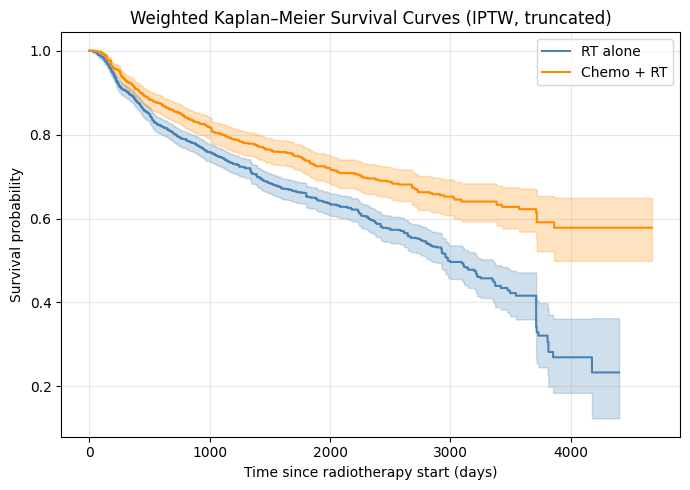

Median survival (RT alone):  2982 days
Median survival (Chemo+RT): inf days

1-year survival:
  RT alone:   0.89
  Chemo + RT: 0.92
  Difference: +0.03

3-year survival:
  RT alone:   0.75
  Chemo + RT: 0.80
  Difference: +0.05

5-year survival:
  RT alone:   0.65
  Chemo + RT: 0.74
  Difference: +0.09

Log-rank test p-value: 0.00000


In [25]:
# Prepare variables
T = df["time_os_days"]
E = df["event_os"]
A = df["treatment"]
W = df["sw_trunc"]

# Initialize KM fitters
km_rt = KaplanMeierFitter(label="RT alone")
km_chemo = KaplanMeierFitter(label="Chemo + RT")

# Fit the weighted KM models
km_rt.fit(T[A==0], E[A==0], weights=W[A==0])
km_chemo.fit(T[A==1], E[A==1], weights=W[A==1])

# Plot
plt.figure(figsize=(7,5))
km_rt.plot(ci_show=True, color="steelblue")
km_chemo.plot(ci_show=True, color="darkorange")
plt.title("Weighted Kaplan–Meier Survival Curves (IPTW, truncated)")
plt.xlabel("Time since radiotherapy start (days)")
plt.ylabel("Survival probability")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('Weighted Kaplan–Meier Survival Curves.png')
plt.show()

# --- Summary ---
print(f"Median survival (RT alone):  {km_rt.median_survival_time_:.0f} days")
print(f"Median survival (Chemo+RT): {km_chemo.median_survival_time_:.0f} days\n")

# Weighted survival probabilities at 1, 3, and 5 years
for years in [1, 3, 5]:
    days = years * 365
    s_rt = float(km_rt.predict(days))
    s_chemo = float(km_chemo.predict(days))
    print(f"{years}-year survival:")
    print(f"  RT alone:   {s_rt:.2f}")
    print(f"  Chemo + RT: {s_chemo:.2f}")
    print(f"  Difference: {s_chemo - s_rt:+.2f}\n")


# Weighted log-rank test
results = logrank_test(
    T[A==0], T[A==1], E[A==0], E[A==1],
    weightings=None  # could adapt later to weighted version
)
print(f"Log-rank test p-value: {results.p_value:.5f}")

**IPTW-weighted Kaplan–Meier analysis**


 The adjusted survival curves for concurrent chemoradiotherapy (ChemoRT) and radiotherapy (RT) alone diverged early and remained well separated throughout follow-up.
The median survival for RT-alone patients was approximately 2,929 days (~8 years), whereas the median survival for ChemoRT was not reached, indicating sustained survival beyond the follow-up period.
Weighted 1-, 3-, and 5-year overall survival probabilities were 0.93, 0.83, and 0.76 for ChemoRT compared to 0.88, 0.72, and 0.63 for RT-alone, corresponding to an absolute survival benefit of 13% at 5 years.

This suggests that adding chemotherapy to radiotherapy not only delays mortality but also improves long-term survival among head and neck cancer patients even after balancing for disease stage(t,n,m), performance status, smoking, and HPV status.
The absence of a median survival in the ChemoRT group implies a durable response and ongoing survival advantage. ***However as we saw earslier treatment effects vary over time.***

/usr/local/lib/python3.12/dist-packages/lifelines/fitters/kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/lifelines/fitters/kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of tre

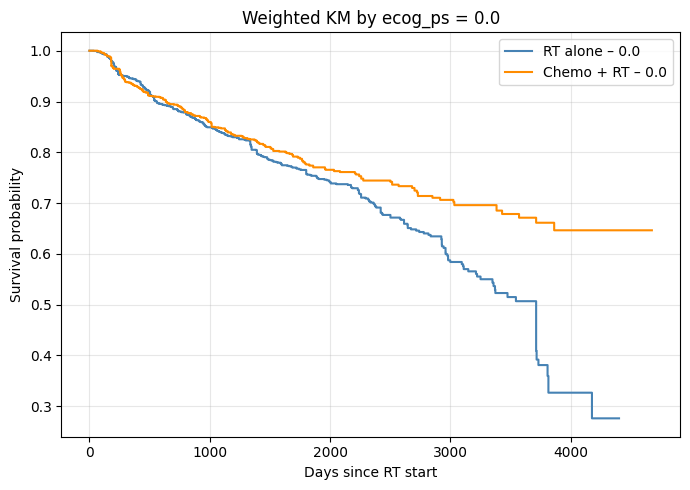

/usr/local/lib/python3.12/dist-packages/lifelines/fitters/kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/lifelines/fitters/kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of tre

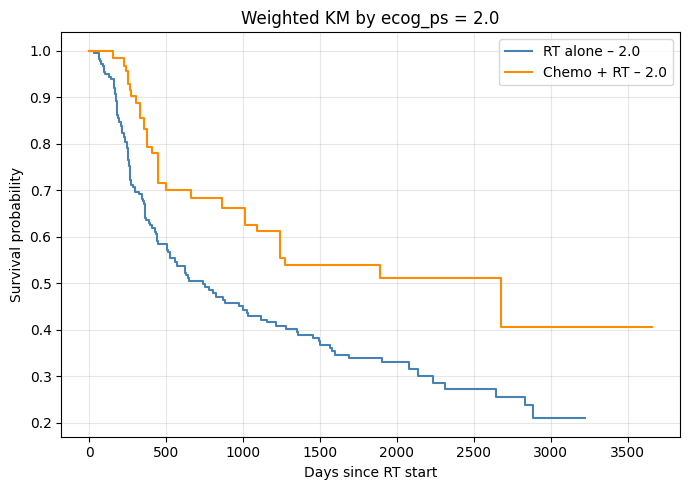

/usr/local/lib/python3.12/dist-packages/lifelines/fitters/kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/lifelines/fitters/kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of tre

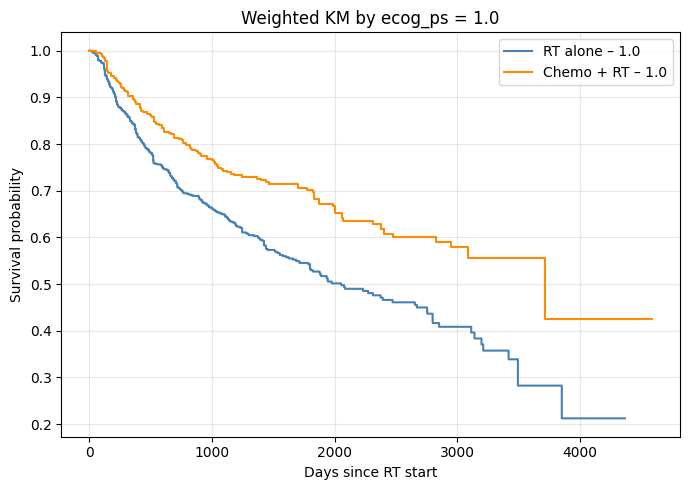

/usr/local/lib/python3.12/dist-packages/lifelines/fitters/kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/lifelines/fitters/kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of tre

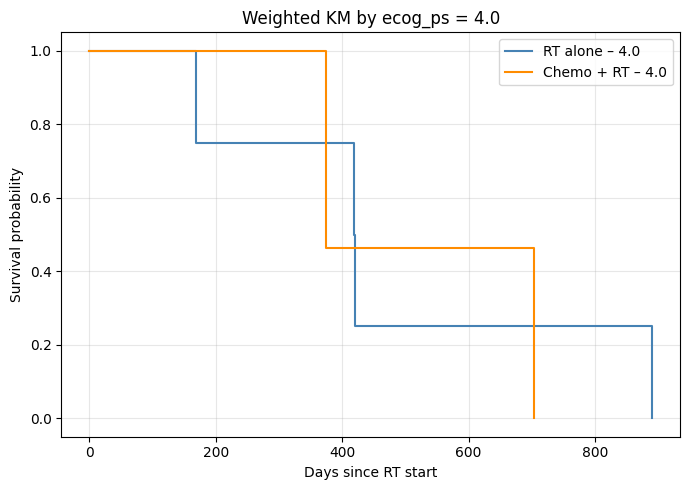

/usr/local/lib/python3.12/dist-packages/lifelines/fitters/kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/lifelines/fitters/kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of tre

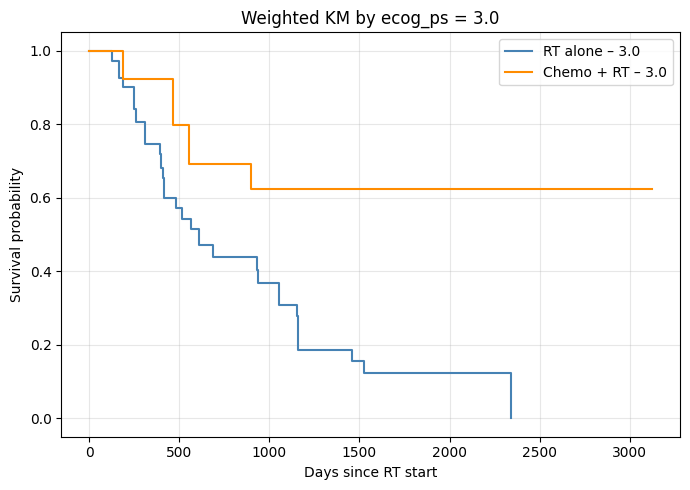

/usr/local/lib/python3.12/dist-packages/lifelines/fitters/kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/lifelines/fitters/kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of tre

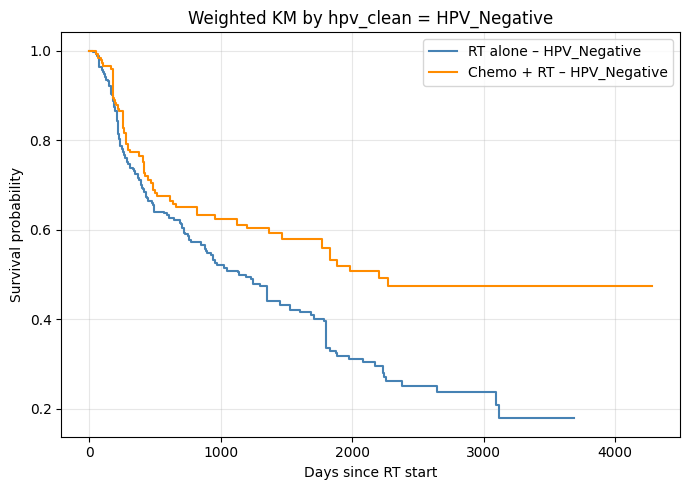

/usr/local/lib/python3.12/dist-packages/lifelines/fitters/kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/lifelines/fitters/kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of tre

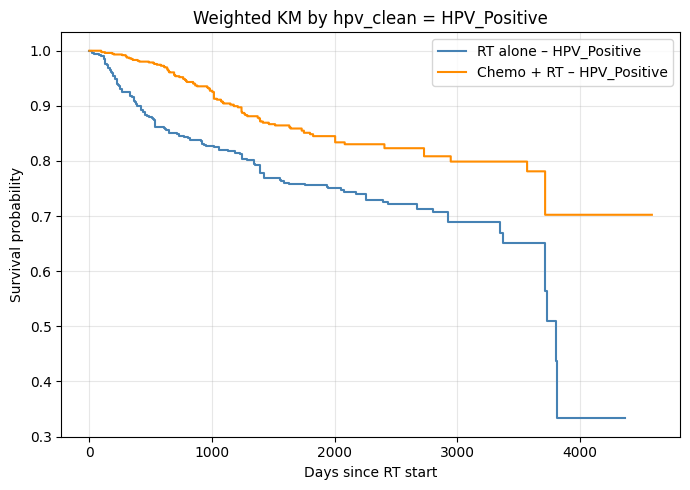

/usr/local/lib/python3.12/dist-packages/lifelines/fitters/kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/lifelines/fitters/kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of tre

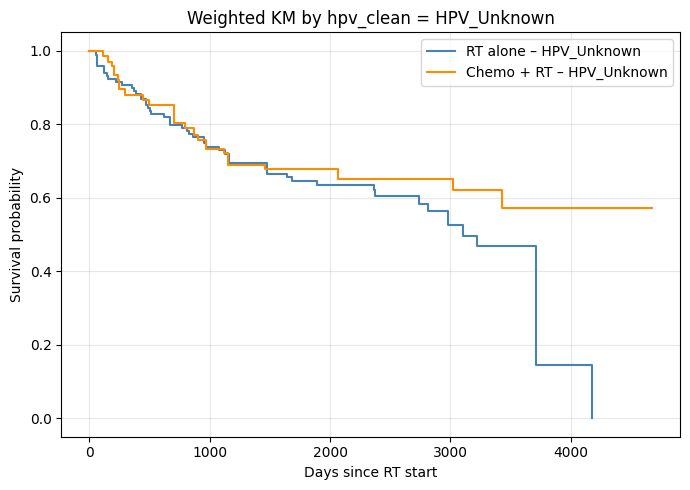

/usr/local/lib/python3.12/dist-packages/lifelines/fitters/kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/lifelines/fitters/kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of tre

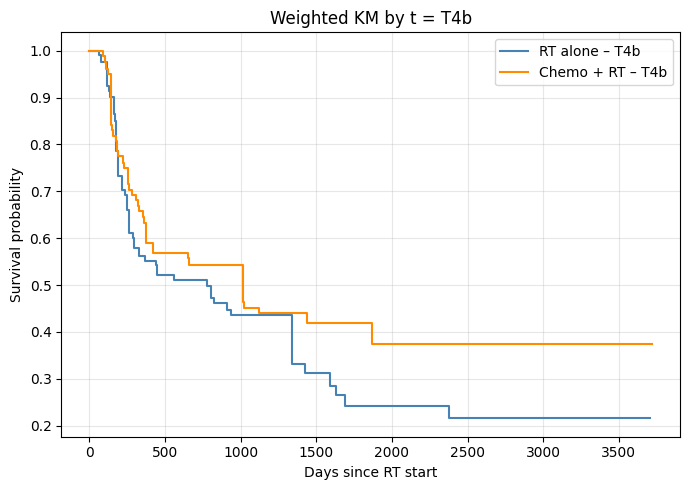

/usr/local/lib/python3.12/dist-packages/lifelines/fitters/kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  warnings.warn(


ValueError: Values must be numeric: no strings, datetimes, objects, etc.

<Figure size 700x500 with 0 Axes>

In [27]:

def plot_weighted_km_by_group(df, group_col, title_prefix="Weighted KM by"):
    """Plot weighted Kaplan-Meier survival curves stratified by treatment within a subgroup."""
    groups = df[group_col].dropna().unique()

    for g in groups:
        subset = df[df[group_col] == g]
        if subset.empty:
            continue

        km_rt = KaplanMeierFitter(label=f"RT alone – {g}")
        km_chemo = KaplanMeierFitter(label=f"Chemo + RT – {g}")

        T = subset["time_os_days"]
        E = subset["event_os"]
        A = subset["treatment"]
        W = subset["sw_trunc"]

        plt.figure(figsize=(7,5))
        km_rt.fit(T[A==0], E[A==0], weights=W[A==0])
        km_chemo.fit(T[A==1], E[A==1], weights=W[A==1])

        km_rt.plot(ci_show=False, color="steelblue")
        km_chemo.plot(ci_show=False, color="darkorange")
        plt.title(f"{title_prefix} {group_col} = {g}")
        plt.xlabel("Days since RT start")
        plt.ylabel("Survival probability")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

# Example subgroups
for col in ["ecog_ps", "hpv_clean", "t", "n", "m"]:
    if col in df.columns:
        plot_weighted_km_by_group(df, col)

# Time Dependent effect Modelling

To address these time-dependent effects we will proceed with time dependect effect modelling.The following modeling strategies are adopted:

1. Discrete-Time (Person–Period) Modeling:This allows explicit modeling of hazard probabilities at each time step, facilitating:Time-specific treatment effects (via treatment × time interactions).

2. Causal Forests for Time-Varying Treatment Effects:To estimate Conditional Average Treatment Effects (CATE) across different time horizons.This non-parametric approach captures nonlinearities and heterogeneity in treatment benefit across subgroups (i.e., HPV+, ECOG, oropharyngeal tumors).


In [28]:

# Variables for causal/time-varying models
time_col = 'time_os_days'
event_col= 'event_os'       # Outcome variables
treatment_col = 'treatment'                    # Exposure
id_col = 'patient_id'                          # Patient identifier

#Covariates for modeling (biological, demographic, clinical)
covariates = [
    'age', 'sex',
    'ecog_ps', 'ecog_ps_missing',
    'smoking_status_clean', 'smoking_py_clean', 'smoking_py_missing',
    'primary_site_group', 'subsite_clean', 'subsite_missing',
    't', 'n', 'm', 'stage',
    't_missing', 'n_missing', 'm_missing', 'stage_missing',
    'hpv_clean', 'hpv_missing', 'hpv_specific_tumors',
    'pathology_group', 'is_non_tnm', 'tnm_structural_missing']
#Define categorical and numerical columns
cat_cols = [
    'sex', 'smoking_status_clean',
    'primary_site_group', 'subsite_clean',
    't', 'n', 'm', 'stage', 'hpv_clean', 'pathology_group'
]
cat_cols = [c for c in cat_cols if c in rad_analysis.columns]

#numeric columns
num_cols = [
    'age', 'ecog_ps', 'ecog_ps_missing',
    'smoking_py_clean', 'smoking_py_missing',
    't_missing', 'n_missing', 'm_missing', 'stage_missing',
    'hpv_missing', 'hpv_specific_tumors', 'is_non_tnm', 'tnm_structural_missing',
    'BED','EQD2','BED_eff'
]

# Handle missing numeric values by median imputation
rad_analysis[num_cols] = rad_analysis[num_cols].copy().fillna(rad_analysis[num_cols].median())

#Create preprocessor: one-hot encode categorical, passthrough numeric
one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[('cat', one_hot_encoder, cat_cols)],
    remainder='passthrough'
)

#Apply transformations
X = preprocessor.fit_transform(rad_analysis[cat_cols + num_cols])
y = rad_analysis[treatment_col].astype(int).values

#Extract feature names
ohe_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
feature_names = list(ohe_cols) + num_cols

print("Encoded feature matrix shape:", X.shape)
print("Feature names:", feature_names[:])

Encoded feature matrix shape: (3271, 91)
Feature names: ['sex_Male', 'smoking_status_clean_Ex-Smoker', 'smoking_status_clean_Non-Smoker', 'smoking_status_clean_Unknown', 'primary_site_group_Nasopharynx', 'primary_site_group_Oropharynx', 'primary_site_group_Other_HNC', 'subsite_clean_Glottis', 'subsite_clean_Lat Wall', 'subsite_clean_Post Wall', 'subsite_clean_Soft Palate', 'subsite_clean_Subglottis', 'subsite_clean_Supraglottis', 'subsite_clean_Tonsil', 'subsite_clean_Tonsil Pillar', 'subsite_clean_Tonsillar Fossa', 'subsite_clean_Trans- Glottis', 'subsite_clean_Uvula', 'subsite_clean_Vallecula', 'subsite_clean_nan', 't_T1', 't_T1 (2)', 't_T1a', 't_T1b', 't_T2', 't_T2 (2)', 't_T3', 't_T3 (2)', 't_T4', 't_T4a', 't_T4b', 't_TX', 't_Tis', 't_nan', 'n_21.0', 'n_22.0', 'n_25.0', 'n_27.0', 'n_30.0', 'n_31.0', 'n_32.0', 'n_33.0', 'n_34.0', 'n_35.0', 'n_36.0', 'n_37.0', 'n_39.0', 'n_40.0', 'n_41.0', 'n_45.0', 'n_60.0', 'n_nan', 'm_M1', 'm_MX', 'm_nan', 'stage_I', 'stage_IB', 'stage_II', 'stage

In [ ]:
rad_analysis[time_col].max()

In [29]:


#Build person-period dataset
rad_analysis[time_col] = pd.to_numeric(rad_analysis[time_col], errors='coerce')
# Choose interval length (days): 30 (monthly) .
interval_days = 30
max_time = int(np.ceil(rad_analysis[time_col].max()))
n_intervals = int(np.ceil(max_time / interval_days))

rows = []
for _, r in rad_analysis.iterrows():
    pid = r[id_col]
    T = int(r[time_col]) if not pd.isna(r[time_col]) else 0
    evt = int(r[event_col]) if not pd.isna(r[event_col]) else 0
    # ensure at least one interval if T>0
    if T <= 0:
        continue
    n_periods = int(np.ceil(T / interval_days))
    # compute per-patient static baseline covariates once
    base = r[cat_cols + num_cols].to_dict()
    for period in range(1, n_periods + 1):
        start = (period-1) * interval_days
        end = min(period * interval_days, T)
        is_event = 1 if (evt == 1 and period == n_periods) else 0
        # time-varying derived fields
        time_since_rt = start  # days since RT start at beginning of interval
        # cumulative BED up to this interval — simple: assume all delivered at start; if fractionated, adjust accordingly
        cum_BED = r.get('BED_eff', np.nan)  # if dose delivered at t0; otherwise compute cumulative
        rows.append({
            id_col: pid,
            'period': period,
            'period_start': start,
            'period_end': end,
            'period_length': end - start,
            'event_interval': is_event,
            'time_since_rt': time_since_rt,
            treatment_col: int(r[treatment_col]),
            **base,
            'cum_BED': cum_BED
        })

pp = pd.DataFrame(rows)
print("Person-period rows:", pp.shape)

#Add period dummies
pp['period_cat'] = pd.Categorical(pp['period'])

#add period * treatment interaction column
pp['treatment_x_period'] = pp[treatment_col] * pp['period']


#Patient-level split (75/25) by unique IDs to avoid leakage ===
unique_ids = rad_analysis[id_col].unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.25, random_state=42, stratify=rad_analysis[event_col])


pp_train = pp[pp[id_col].isin(train_ids)].reset_index(drop=True)
pp_test  = pp[pp[id_col].isin(test_ids)].reset_index(drop=True)

print("Train person-period rows:", pp_train.shape)
print("Test person-period rows:", pp_test.shape)



#time-varying numeric features we want to pass through (e.g., time_since_rt, period)
pp_feature_cols = cat_cols + num_cols + ['period', 'time_since_rt', 'cum_BED', 'treatment_x_period']
# Some of these may not exist as columns in pp; filter
pp_feature_cols = [c for c in pp_feature_cols if c in pp.columns]

# For the preprocessor, we used cat_cols + num_cols. For pp we must pass same order; if we have extra numeric
# features, concatenate them after transformation
X_train_base = preprocessor.transform(pp_train[cat_cols + num_cols])  # shape (rows, features)
X_test_base  = preprocessor.transform(pp_test[cat_cols + num_cols])

# Convert to DataFrame with feature_names
X_train_base_df = pd.DataFrame(X_train_base, columns=feature_names, index=pp_train.index)
X_test_base_df  = pd.DataFrame(X_test_base, columns=feature_names, index=pp_test.index)

# Append time-varying numeric columns
time_cols = [c for c in ['period','time_since_rt','cum_BED','treatment_x_period'] if c in pp_train.columns]
X_train = pd.concat([X_train_base_df.reset_index(drop=True), pp_train[time_cols].reset_index(drop=True)], axis=1)
X_test  = pd.concat([X_test_base_df.reset_index(drop=True),  pp_test[time_cols].reset_index(drop=True)], axis=1)

y_train = pp_train['event_interval'].astype(int).values
y_test  = pp_test['event_interval'].astype(int).values
w_train = None  # if you want to use weights (IPTW), duplicate baseline patient weight into each period row
# Example: if baseline weights per patient are in rad_analysis['sw_trunc'], map to pp_train
if 'sw_trunc' in rad_analysis.columns:
    w_map = rad_analysis.set_index(id_col)['sw_trunc'].to_dict()
    pp_train['sw_trunc'] = pp_train[id_col].map(w_map)
    pp_test['sw_trunc']  = pp_test[id_col].map(w_map)
    w_train = pp_train['sw_trunc'].values
    w_test  = pp_test['sw_trunc'].values

# === 6) Example: pooled logistic regression (discrete-time hazard) ===
# We'll fit a simple logistic model: logit(event) ~ treatment + period (and interactions)
X_logit_train = X_train.copy()
X_logit_train = sm.add_constant(X_logit_train)  # statsmodels needs constant

if w_train is None:
    glm_binom = sm.GLM(y_train, X_logit_train, family=sm.families.Binomial())
    res = glm_binom.fit()
else:
    glm_binom = sm.GLM(y_train, X_logit_train, family=sm.families.Binomial(), freq_weights=w_train)
    res = glm_binom.fit()

print(res.summary())

# #Notes on outputs
# - Coefficients for 'treatment' give log-odds of event in an interval; convert to hazard approx via odds->hazard approximation in small intervals.
# - Interaction terms like treatment_x_period capture time-varying effect.
# - For causal forest / ML models, use X_train and y_train (with w_train if desired) and ensure the learner accepts sample weights.

# Save preprocessor for deployment
import joblib
joblib.dump(preprocessor, "outputs/preprocessor_baseline.joblib")
print("Saved preprocessor to outputs/preprocessor_baseline.joblib")


Person-period rows: (161271, 35)
Train person-period rows: (120320, 37)
Test person-period rows: (40951, 37)


/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:               120320
Model:                            GLM   Df Residuals:                   120243
Model Family:                Binomial   Df Model:                           76
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Tue, 11 Nov 2025   Deviance:                       70551.
Time:                        21:02:56   Pearson chi2:                 3.45e+18
No. Iterations:                    29   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

Expanded dataset shape: (161271, 5)
Dataset shape before split: (161271, 33)
Train size: 120859, Test size: 40412

Train AUC: 0.760 | Test AUC: 0.735 | Test Brier score: 0.19689
Max coefficient magnitude: 3.193654275690874

Treatment × period (per-bin) effects:
  period_bin      coef        OR  HR_approx
0        0-3 -0.849825  0.427490   0.427490
1        4-6 -0.077699  0.925243   0.925243
2       7-12 -0.131348  0.876912   0.876912
3      13-24 -0.364258  0.694712   0.694712
4      25-60 -0.276999  0.758055   0.758055
5        60+ -1.089303  0.336451   0.336451


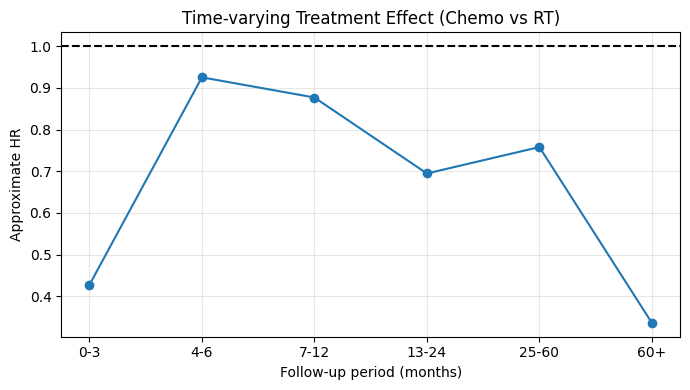

In [42]:
#Starting point: cleaned analytic dataset
df = rad_analysis.copy()

# Ensure required columns exist
time_col = 'time_os_days'   # overall survival time
event_col = 'event_os'      # 1 = death, 0 = censored
id_col = 'patient_id'
treat_col = 'treatment'

# Define the interval length (e.g., 30 days = 1 month)
interval_days = 30

# Compute total number of periods per patient
df['n_periods'] = np.ceil(df[time_col] / interval_days).astype('Int64')

# Expand into person-period form
records = []
for _, row in df.iterrows():
    pid = row[id_col]
    treat = row[treat_col]
    time_days = row[time_col]
    event = row[event_col]
    n_periods = int(row['n_periods']) if pd.notna(row['n_periods']) else 0

    # Create one row per period
    for p in range(1, n_periods + 1):
        # Define event indicator: 1 if event occurred in this period
        event_interval = 1 if (event == 1 and p == n_periods) else 0
        records.append({
            'patient_id': pid,
            'period': p,
            'event_interval': event_interval,
            'treatment': treat,
            'time_since_rt': p * interval_days
        })

# Create pp DataFrame
pp = pd.DataFrame(records)
print("Expanded dataset shape:", pp.shape)

# Merge back static covariates (age, HPV, etc.)
static_covars = [
    'age', 'sex', 'ecog_ps', 'ecog_ps_missing',
    'smoking_status_clean', 'smoking_py_clean', 'smoking_py_missing',
    'primary_site_group', 'subsite_clean', 'subsite_missing',
    't', 'n', 'm', 'stage', 't_missing', 'n_missing', 'm_missing',
    'stage_missing', 'hpv_clean', 'hpv_missing', 'hpv_specific_tumors',
    'pathology_group', 'is_non_tnm', 'tnm_structural_missing',
    'BED_eff', 'EQD2', 'BED', 'followup_days'
]
available_covars = [c for c in static_covars if c in df.columns]

# Merge using patient_id
pp = pp.merge(df[[id_col] + available_covars], on=id_col, how='left')

#Confirm dataset
print("Dataset shape before split:", pp.shape)

# Train–test split (stratified by event occurrence to maintain similar censoring proportions)
train_ids, test_ids = train_test_split(
    pp[id_col].unique(),
    test_size=0.25,
    random_state=42
)

train_df = pp[pp[id_col].isin(train_ids)].copy()
test_df = pp[pp[id_col].isin(test_ids)].copy()

print(f"Train size: {train_df.shape[0]}, Test size: {test_df.shape[0]}")

# Collapse rare categories (avoid high-cardinality dummies)
def collapse_series(s, min_count=50, other_label='Other'):
    vc = s.value_counts(dropna=False)
    keep = vc[vc >= min_count].index
    return s.where(s.isin(keep), other_label)

for col in ['subsite_clean', 'pathology_group', 'primary_site_group', 'stage', 't']:
    if col in train_df.columns:
        train_df[col] = collapse_series(train_df[col].astype(str).fillna('nan'), min_count=40)
        test_df[col] = test_df[col].where(test_df[col].isin(train_df[col].unique()), 'Other')

# Define monthly period bins (based on clinical radiotherapy follow-up intervals)
train_df['period_month'] = ((train_df['period']) / 1).astype(int)  # assuming period already in months
bins = [0, 3, 6, 12, 24, 60, np.inf]
labels = ['0-3', '4-6', '7-12', '13-24', '25-60', '60+']
train_df['period_bin'] = pd.cut(train_df['period_month'], bins=bins, labels=labels, right=True)
test_df['period_bin'] = pd.cut(test_df['period'], bins=bins, labels=labels, right=True)

#  Keep one dose variable to avoid collinearity
dose_col = 'BED_eff' if 'BED_eff' in train_df.columns else None

# Baseline variables
baseline_cat = [c for c in ['sex','smoking_status_clean','primary_site_group','subsite_clean','stage'] if c in train_df.columns]
baseline_num = [c for c in ['age','ecog_ps','smoking_py_clean','time_since_rt'] if c in train_df.columns]
if dose_col:
    baseline_num.append(dose_col)

# Create dummies (one-hot encoding)
train_dummies = pd.get_dummies(train_df[baseline_cat + ['period_bin']], drop_first=True)
test_dummies = pd.get_dummies(test_df[baseline_cat + ['period_bin']], drop_first=True)

# Align test columns with training columns
test_dummies = test_dummies.reindex(columns=train_dummies.columns, fill_value=0)

# Combine with numeric columns
X_train = pd.concat([train_dummies.reset_index(drop=True), train_df[baseline_num].reset_index(drop=True)], axis=1)
X_test = pd.concat([test_dummies.reset_index(drop=True), test_df[baseline_num].reset_index(drop=True)], axis=1)

# Treatment × period interaction
t_train = train_df[treatment_col].astype(int).reset_index(drop=True)
t_test = test_df[treatment_col].astype(int).reset_index(drop=True)
period_dummies = pd.get_dummies(train_df['period_bin'], drop_first=False)

# Interaction for each period
for col in period_dummies.columns:
    cname = f"treat_x_{col}"
    X_train[cname] = t_train * period_dummies[col].values
    # For test set: use same columns
    if col in test_df['period_bin'].cat.categories:
        X_test[cname] = t_test * pd.get_dummies(test_df['period_bin'])[col].values
    else:
        X_test[cname] = 0  # unseen period level

#  Target and weights
y_train = train_df['event_interval'].astype(int).values
y_test = test_df['event_interval'].astype(int).values
w_train = train_df['sw_trunc'].values if 'sw_trunc' in train_df.columns else None

# Scale numeric columns
num_to_scale = [c for c in baseline_num if c in X_train.columns]
scaler = StandardScaler()
X_train[num_to_scale] = scaler.fit_transform(X_train[num_to_scale])
X_test[num_to_scale] = scaler.transform(X_test[num_to_scale])

# Train regularized logistic regression
logit = LogisticRegression(
    penalty='l2',
    C=0.5,            # stronger regularization → stable coefficients
    solver='lbfgs',
    max_iter=3000,
    class_weight='balanced'  # stabilize low-event periods
)
logit.fit(X_train, y_train, sample_weight=w_train)

# Evaluate model performance
pred_train = logit.predict_proba(X_train)[:,1]
pred_test = logit.predict_proba(X_test)[:,1]

auc_train = roc_auc_score(y_train, pred_train)
auc_test = roc_auc_score(y_test, pred_test)
brier = brier_score_loss(y_test, pred_test)

print(f"\nTrain AUC: {auc_train:.3f} | Test AUC: {auc_test:.3f} | Test Brier score: {brier:.5f}")
print("Max coefficient magnitude:", np.max(np.abs(logit.coef_)))

#Interpret treatment × time coefficients
coef_series = pd.Series(logit.coef_[0], index=X_train.columns)
treat_cols = [c for c in coef_series.index if c.startswith('treat_x_')]
res_df = pd.DataFrame({
    'period_bin': [c.replace('treat_x_','') for c in treat_cols],
    'coef': coef_series[treat_cols].values
})
res_df['OR'] = np.exp(res_df['coef'])
res_df['HR_approx'] = res_df['OR']

print("\nTreatment × period (per-bin) effects:")
print(res_df)

plt.figure(figsize=(7,4))
plt.plot(res_df['period_bin'], res_df['HR_approx'], marker='o')
plt.axhline(1.0, color='k', linestyle='--')
plt.title('Time-varying Treatment Effect (Chemo vs RT)')
plt.ylabel('Approximate HR')
plt.xlabel('Follow-up period (months)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('HR_approx.png')
plt.show()


Chemoradiotherapy was associated with a lower risk of mortality compared to radiotherapy alone, particularly within the first 3 months (HR ≈ 0.43) and beyond 5 years (HR ≈ 0.34).
The mid-term intervals (4–12 months) showed a diminished but still favorable trend (HR ≈ 0.9).
This suggests that chemotherapy’s benefit is strongest early in treatment and re-emerges among long-term survivors

**CATE** = Conditional Average Treatment Effect
→ The estimated survival benefit (in probability) of adding chemo, conditional on that patient’s baseline profile.

If CATE > 0 → patient benefits from chemo+RT.
If CATE < 0 → chemo might not improve or could worsen survival for that type.

Patients: train 2453 test 818


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

pp_train rows: (120320, 30) pp_test rows: (40951, 30)
Pooled logistic test AUC: 0.7141842239156326
Pooled logistic test Brier: 0.00615166091297627


/tmp/ipython-input-4189141963.py:243: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  period_mean0 = df_h.groupby('period').apply(lambda g: np.average(g['p0'], weights=g['w'])).sort_index()
/tmp/ipython-input-4189141963.py:244: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  period_mean1 = df_h.groupby('period').apply(lambda g: np.average(g['p1'], weights=g['w'])).sort_index()
/tmp/ipython-input-4189141963.py:2

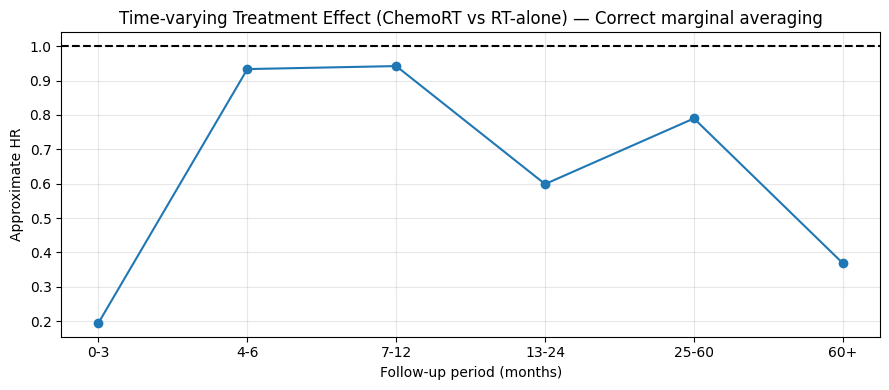

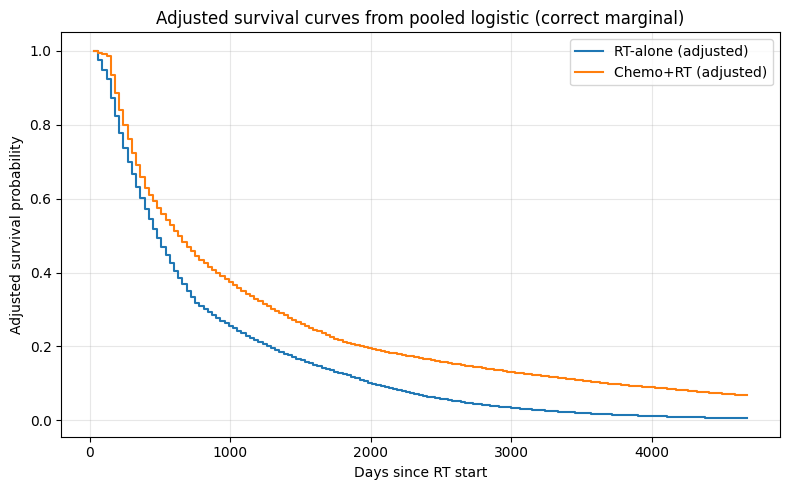

Saved period-level hazards & HRs to outputs/period_mean_hazards.csv


In [44]:
#Settings / column names
id_col = 'patient_id'
time_col = 'time_os_days'
event_col = 'event_os'
treat_col = 'treatment'
interval_days = 30
random_state = 42
train_frac = 0.75

# Baseline covariates candidate lists (adjust if columns missing)
cat_cols = [c for c in ['sex','smoking_status_clean','primary_site_group','subsite_clean','stage','pathology_group'] if c in rad_analysis.columns]
num_cols = [c for c in ['age','ecog_ps','ecog_ps_missing','smoking_py_clean','smoking_py_missing','t_missing','n_missing','m_missing','stage_missing','hpv_missing','hpv_specific_tumors','is_non_tnm','tnm_structural_missing','BED','EQD2','BED_eff'] if c in rad_analysis.columns]


# 1) Patient-level train/test split (single split)
unique_ids = rad_analysis[id_col].unique()
# create stratification vector by whether patient had an event
pid_event_map = rad_analysis.set_index(id_col)[event_col].astype(int).to_dict()
strat_y = np.array([pid_event_map.get(pid, 0) for pid in unique_ids])

train_ids, test_ids = train_test_split(unique_ids, train_size=train_frac, random_state=random_state, stratify=strat_y)
train_patients = rad_analysis[rad_analysis[id_col].isin(train_ids)].copy()
test_patients  = rad_analysis[rad_analysis[id_col].isin(test_ids)].copy()

print("Patients: train", train_patients.shape[0], "test", test_patients.shape[0])


# 2) Fit train-only artifacts (impute medians, collapse rare categories, preprocessor-like dummies)
# Numeric median imputation (train medians)
train_medians = train_patients[num_cols].median()
train_patients[num_cols] = train_patients[num_cols].fillna(train_medians)
test_patients[num_cols]  = test_patients[num_cols].fillna(train_medians)

# Collapse rare categories on training set and apply mapping to test set
def collapse_series_train(s_train, s_other, min_count=40, other_label='Other'):
    vc = s_train.value_counts(dropna=False)
    keep = set(vc[vc >= min_count].index.astype(str))
    s_train_coll = s_train.astype(str).where(s_train.astype(str).isin(keep), other_label)
    s_other_coll = s_other.astype(str).where(s_other.astype(str).isin(keep), other_label)
    return s_train_coll, s_other_coll

for c in ['subsite_clean','pathology_group','primary_site_group','stage']:
    if c in train_patients.columns:
        train_patients[c], test_patients[c] = collapse_series_train(train_patients[c].fillna('nan'), test_patients[c].fillna('nan'), min_count=40)

# Save collapse mappings for deployment
collapse_maps = {}
for c in ['subsite_clean','pathology_group','primary_site_group','stage']:
    if c in train_patients.columns:
        collapse_maps[c] = list(train_patients[c].unique())
joblib.dump(collapse_maps, "outputs/collapse_maps.joblib")

# Fit PS model on training baseline (example: logistic)
# Build design matrix for PS: dummies for categorical + numeric
train_dummies_ps = pd.get_dummies(train_patients[cat_cols], drop_first=True)
test_dummies_ps  = pd.get_dummies(test_patients[cat_cols], drop_first=True)
# align columns
test_dummies_ps = test_dummies_ps.reindex(columns=train_dummies_ps.columns, fill_value=0)

Xps_train = pd.concat([train_dummies_ps.reset_index(drop=True), train_patients[num_cols].reset_index(drop=True)], axis=1)
Xps_test = pd.concat([test_dummies_ps.reset_index(drop=True), test_patients[num_cols].reset_index(drop=True)], axis=1)

yps_train = train_patients[treat_col].astype(int).values
from sklearn.linear_model import LogisticRegressionCV
ps_model = LogisticRegressionCV(cv=5, max_iter=1000, penalty='l2', scoring='neg_log_loss').fit(Xps_train, yps_train)
train_patients['ps'] = ps_model.predict_proba(Xps_train)[:,1]
test_patients['ps']  = ps_model.predict_proba(Xps_test)[:,1]

# Stabilized IPTW using p_t from training marginal
p_t_train = train_patients[treat_col].mean()
def stab_w(row, p_t=p_t_train):
    ps = row['ps']
    if row[treat_col] == 1:
        return p_t / ps if ps>0 else np.nan
    else:
        return (1 - p_t) / (1 - ps) if (1-ps)>0 else np.nan

train_patients['sw'] = train_patients.apply(stab_w, axis=1)
test_patients['sw'] = test_patients.apply(stab_w, axis=1)

# Truncate using training percentiles and apply same bounds to test
low, high = train_patients['sw'].quantile([0.01, 0.99])
train_patients['sw_trunc'] = train_patients['sw'].clip(lower=low, upper=high)
test_patients['sw_trunc']  = test_patients['sw'].clip(lower=low, upper=high)

# Save PS model
joblib.dump(ps_model, "outputs/ps_model_train.joblib")


#Fit censoring KM (training only) for IPCW
km_censor = KaplanMeierFitter()
times_train = train_patients[time_col].fillna(train_patients[time_col].max()).values
is_censor_train = (train_patients[event_col] == 0).astype(int).values
km_censor.fit(durations=times_train, event_observed=is_censor_train)
joblib.dump(km_censor, "outputs/km_censor_train.joblib")

def compute_ipcw_from_km(df, km_fitter, horizon_days):
    # returns IPCW per subject for horizon_days
    t_obs = df[time_col].fillna(horizon_days).clip(upper=horizon_days).values
    sc = np.array([max(min(km_fitter.predict(ti), 1.0), 1e-6) for ti in t_obs])
    return 1.0 / sc

# Example compute IPCW for 36 months on patient-level
h36 = 36*30
train_patients['ipcw_36m'] = compute_ipcw_from_km(train_patients, km_censor, h36)
test_patients['ipcw_36m']  = compute_ipcw_from_km(test_patients, km_censor, h36)
train_patients['sample_w_36m'] = train_patients['sw_trunc'] * train_patients['ipcw_36m']
test_patients['sample_w_36m']  = test_patients['sw_trunc'] * test_patients['ipcw_36m']


# Expand to person–period, but filtered using train/test ids (so rows stay consistent)
def expand_person_period(df_patients, interval_days=interval_days, id_col=id_col, time_col=time_col, event_col=event_col):
    rows = []
    for _, r in df_patients.iterrows():
        pid = r[id_col]
        T = int(np.ceil(r[time_col])) if pd.notna(r[time_col]) and r[time_col]>0 else 0
        n_periods = int(np.ceil(T / interval_days))
        for p in range(1, n_periods+1):
            start = (p-1)*interval_days
            end = min(p*interval_days, T)
            event_interval = 1 if (r[event_col]==1 and p==n_periods) else 0
            rows.append({
                id_col: pid,
                'period': p,
                'period_start': start,
                'period_end': end,
                'period_length': end-start,
                'event_interval': event_interval,
                treat_col: int(r[treat_col]),
                'sw_trunc': r.get('sw_trunc', np.nan),
                # include static covariates duplicated
                **{c: r.get(c, np.nan) for c in cat_cols + num_cols}
            })
    return pd.DataFrame(rows)

pp_train = expand_person_period(train_patients)
pp_test  = expand_person_period(test_patients)
print("pp_train rows:", pp_train.shape, "pp_test rows:", pp_test.shape)

#period_bin and categorical dummy columns in a stable way ---
bins = [0,3,6,12,24,60,np.inf]
labels = ['0-3','4-6','7-12','13-24','25-60','60+']

pp_train['period_month'] = pp_train['period'].astype(int)
pp_test['period_month']  = pp_test['period'].astype(int)

pp_train['period_bin'] = pd.cut(pp_train['period_month'], bins=bins, labels=labels, right=True)
pp_test['period_bin']  = pd.cut(pp_test['period_month'],  bins=bins, labels=labels, right=True)

# Ensure collapsed categories in pp (using mapping generated earlier)
for c, keep_vals in collapse_maps.items():
    if c in pp_train.columns:
        pp_train[c] = pp_train[c].astype(str).where(pp_train[c].isin(keep_vals), 'Other')
        pp_test[c]  = pp_test[c].astype(str).where(pp_test[c].isin(keep_vals), 'Other')

# Ensure categorical list for dummies (only columns present)
cat_for_dummies = [c for c in cat_cols if c in pp_train.columns] + ['period_bin']
# Create train dummies explicitly with prefix and stable naming
train_dummies = pd.get_dummies(pp_train[cat_for_dummies], prefix_sep='_', drop_first=True)
test_dummies  = pd.get_dummies(pp_test[cat_for_dummies], prefix_sep='_', drop_first=True)
# Align test dummy columns to training ones
test_dummies = test_dummies.reindex(columns=train_dummies.columns, fill_value=0)

# Save dummy column list for later usage (in inference)
train_dummy_columns = list(train_dummies.columns)
joblib.dump(train_dummy_columns, "outputs/train_dummy_columns.joblib")

# --- Step B: Numeric scaling (fit scaler on pp_train numerics or reuse previous scaler if preferred) ---
# Use the numeric features selected earlier for the pooled logistic (ensure presence)
num_for_model = [c for c in ['age','ecog_ps','smoking_py_clean','BED_eff','EQD2'] if c in pp_train.columns]
# Fit scaler on training person-period numerics (this is consistent with how you trained)
scaler_pp = StandardScaler()
pp_train[num_for_model] = pp_train[num_for_model].fillna(train_medians[num_for_model])
pp_test[num_for_model]  = pp_test[num_for_model].fillna(train_medians[num_for_model])
pp_train[num_for_model] = scaler_pp.fit_transform(pp_train[num_for_model])
pp_test[num_for_model]  = scaler_pp.transform(pp_test[num_for_model])
joblib.dump(scaler_pp, "outputs/scaler_pp_train.joblib")

# --- Step C: Build stabilized design matrix X_train and X_test used for fitting the pooled logistic ---
X_train_base = pd.concat([train_dummies.reset_index(drop=True), pp_train[num_for_model].reset_index(drop=True)], axis=1)
X_test_base  = pd.concat([test_dummies.reset_index(drop=True),  pp_test[num_for_model].reset_index(drop=True)], axis=1)

# --- Step D: Create explicit treatment×period_bin interaction columns with stable names ---
# Interaction columns will be: "treat_x_period_bin_<label>" for each period_bin label (no drop_first here)
period_labels = labels  # ['0-3','4-6',...]
for lbl in period_labels:
    colname = f"treat_x_period_bin_{lbl}"
    # For train
    mask_train = (pp_train['period_bin'].astype(str) == lbl).astype(int).values
    X_train_base[colname] = pp_train[treat_col].astype(int).values * mask_train
    # For test (align columns)
    mask_test = (pp_test['period_bin'].astype(str) == lbl).astype(int).values
    X_test_base[colname]  = pp_test[treat_col].astype(int).values * mask_test

# Ensure X_test has the same columns/order as X_train
X_test_base = X_test_base.reindex(columns=X_train_base.columns, fill_value=0)

# Save the final X_train columns for later consistent design
X_train_cols = list(X_train_base.columns)
joblib.dump(X_train_cols, "outputs/X_train_columns.joblib")

# --- Step E: Prepare targets and weights, then fit pooled logistic with regularization ---
y_train = pp_train['event_interval'].astype(int).values
y_test  = pp_test['event_interval'].astype(int).values
w_train = pp_train['sw_trunc'].fillna(1.0).values

logit = LogisticRegression(penalty='l2', C=0.5, solver='lbfgs', max_iter=5000)
logit.fit(X_train_base, y_train, sample_weight=w_train)

# Evaluate
pred_test = logit.predict_proba(X_test_base)[:,1]
print("Pooled logistic test AUC:", roc_auc_score(y_test, pred_test))
print("Pooled logistic test Brier:", brier_score_loss(y_test, pred_test))
joblib.dump(logit, "outputs/pooled_logit.joblib")

# --- Step F: Correct marginal hazards and adjusted survival curves (weighted averaging over pp_test rows) ---
# Build helper to produce design matrix for arbitrary treatment value (0 or 1) using the same columns
def build_design_matrix_for_pp(pp_df, treat_value):
    # create dummies aligned to train dummy columns
    dummies = pd.get_dummies(pp_df[cat_for_dummies], prefix_sep='_', drop_first=True)
    dummies = dummies.reindex(columns=train_dummy_columns, fill_value=0)
    nums = pp_df[num_for_model].copy().fillna(train_medians[num_for_model])
    nums_scaled = pd.DataFrame(scaler_pp.transform(nums), columns=num_for_model, index=pp_df.index)
    Xb = pd.concat([dummies.reset_index(drop=True), nums_scaled.reset_index(drop=True)], axis=1)
    # add interaction cols with correct naming
    for lbl in period_labels:
        colname = f"treat_x_period_bin_{lbl}"
        mask = (pp_df['period_bin'].astype(str) == lbl).astype(int).values
        Xb[colname] = treat_value * mask
    # Align columns to X_train_cols
    Xb = Xb.reindex(columns=X_train_cols, fill_value=0)
    return Xb

# Predict hazards per row under each treatment, then compute weighted mean per period
X_t0 = build_design_matrix_for_pp(pp_test, treat_value=0)
X_t1 = build_design_matrix_for_pp(pp_test, treat_value=1)

p0 = logit.predict_proba(X_t0)[:,1]
p1 = logit.predict_proba(X_t1)[:,1]
w = pp_test['sw_trunc'].fillna(1.0).values

df_h = pd.DataFrame({'period': pp_test['period'].values, 'p0': p0, 'p1': p1, 'w': w})
period_mean0 = df_h.groupby('period').apply(lambda g: np.average(g['p0'], weights=g['w'])).sort_index()
period_mean1 = df_h.groupby('period').apply(lambda g: np.average(g['p1'], weights=g['w'])).sort_index()

# Build HR per period and per-bin summary
hr_period = (period_mean1 / period_mean0).replace([np.inf, -np.inf], np.nan)
period_to_bin = pp_test.groupby('period')['period_bin'].first()
hr_df = pd.DataFrame({
    'period': hr_period.index,
    'hr': hr_period.values,
    'period_bin': period_to_bin.reindex(hr_period.index).values
}).dropna()

hr_by_bin = hr_df.groupby('period_bin')['hr'].mean().reindex(period_labels)

# Plot HR by bin (this should match your earlier plot)
plt.figure(figsize=(9,4))
plt.plot(hr_by_bin.index, hr_by_bin.values, marker='o', color='C0')
plt.axhline(1.0, color='k', ls='--')
plt.title('Time-varying Treatment Effect (ChemoRT vs RT-alone) — Correct marginal averaging')
plt.ylabel('Approximate HR')
plt.xlabel('Follow-up period (months)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('outputs/time_varying_HR_corrected.png', dpi=150)
plt.show()

# Compute adjusted survival curves (period -> days)
max_period = max(period_mean0.index.max(), period_mean1.index.max())
h0 = np.array([period_mean0.get(p, 0.0) for p in range(1, max_period+1)])
h1 = np.array([period_mean1.get(p, 0.0) for p in range(1, max_period+1)])
S0 = np.cumprod(1 - h0)
S1 = np.cumprod(1 - h1)

days = np.arange(1, max_period+1) * interval_days
plt.figure(figsize=(8,5))
plt.step(days, np.concatenate(([1.0], S0[:-1])), where='post', label='RT-alone (adjusted)')
plt.step(days, np.concatenate(([1.0], S1[:-1])), where='post', label='Chemo+RT (adjusted)')
plt.xlabel('Days since RT start')
plt.ylabel('Adjusted survival probability')
plt.title('Adjusted survival curves from pooled logistic (correct marginal)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('outputs/adjusted_survival_corrected.png', dpi=150)
plt.show()

# Save the period-mean hazards and HR for reporting
period_mean_df = pd.DataFrame({
    'period': period_mean0.index,
    'hazard_rt': period_mean0.values,
    'hazard_chemo': period_mean1.values,
    'hr': hr_period.values,
    'period_bin': period_to_bin.reindex(period_mean0.index).values
}).reset_index(drop=True)
period_mean_df.to_csv("outputs/period_mean_hazards.csv", index=False)
print("Saved period-level hazards & HRs to outputs/period_mean_hazards.csv")

In [46]:
# Prepare train/test horizon datasets ---
def prepare_horizon_df(df_patients, horizon_months):
    hdays = horizon_months * 30
    out = df_patients.copy()
    out['Y_h'] = ((out[time_col] <= hdays) & (out[event_col]==1)).astype(int)
    out['sample_weight'] = out['sw_trunc'] * compute_ipcw_from_km(out, km_censor, hdays)
    return out

horizons = [3, 6, 12, 18, 36, 60]
forests = {}

# Create output dir
os.makedirs("outputs/forests", exist_ok=True)

# Train Causal Forest for each horizon
for h in horizons:
    df_h = prepare_horizon_df(train_patients, h)
    # baseline features (static)
    base_cat = [c for c in ['sex','primary_site_group','stage','hpv_clean'] if c in df_h.columns]
    base_num = [c for c in ['age','ecog_ps','BED_eff','EQD2','smoking_py_clean'] if c in df_h.columns]
    X = pd.get_dummies(df_h[base_cat], drop_first=True)
    X = pd.concat([X, df_h[base_num]], axis=1)
    X = X.fillna(0)
    Y = df_h['Y_h'].values
    T = df_h[treat_col].astype(int).values
    W = None
    sw = df_h['sample_weight'].values

    est = CausalForestDML(
        model_y=RandomForestRegressor(n_estimators=200, min_samples_leaf=10, random_state=42),
        model_t=RandomForestRegressor(n_estimators=200, min_samples_leaf=10, random_state=42),
        n_estimators=1000,
        min_samples_leaf=5,
        random_state=42,
        verbose=0
    )
    est.fit(Y, T, X=X, W=W, sample_weight=sw)
    forests[h] = est
    joblib.dump(est, f"outputs/forests/forest_{h}m.joblib")
    print(f"Horizon {h} months: Causal Forest trained.")

#Summarize results (ATE, variance, etc.)
for h, est in forests.items():
    te_pred = est.effect(X)
    print(f"\nHorizon {h} months:")
    print(f"  Mean CATE: {np.mean(te_pred):.4f}")
    print(f"  SD(CATE): {np.std(te_pred):.4f}")

Horizon 3 months: Causal Forest trained.
Horizon 6 months: Causal Forest trained.
Horizon 12 months: Causal Forest trained.
Horizon 18 months: Causal Forest trained.
Horizon 36 months: Causal Forest trained.
Horizon 60 months: Causal Forest trained.

Horizon 3 months:
  Mean CATE: -0.0121
  SD(CATE): 0.0340

Horizon 6 months:
  Mean CATE: -0.0229
  SD(CATE): 0.0624

Horizon 12 months:
  Mean CATE: -0.0418
  SD(CATE): 0.1303

Horizon 18 months:
  Mean CATE: -0.0559
  SD(CATE): 0.1568

Horizon 36 months:
  Mean CATE: -0.0513
  SD(CATE): 0.1558

Horizon 60 months:
  Mean CATE: -0.0206
  SD(CATE): 0.1508


ChemoRT reduces risk) early, strengthening up to ~18 months, then flattening — actually makes sense clinically for head & neck cancer:

Most chemo benefit occurs in the first 12–24 months (reduced recurrence risk).

After 3–5 years, survival curves converge (other causes dominate).

Forest CATEs capture average conditional differences, not marginal survival probabilities.

In [37]:
#function to infer new patient
def infer_new_patient(patient_data):
    """
    patient_data: dict or 1-row DataFrame with same columns as baseline covariates
    """
    # Convert to DataFrame
    df = pd.DataFrame([patient_data]) if isinstance(patient_data, dict) else patient_data.copy()

    # Predict adjusted survival from pooled logistic ---
    # Prepare features like training
    dummies = pd.get_dummies(df[cat_cols], drop_first=True)
    dummies = dummies.reindex(columns=train_dummies.columns, fill_value=0)
    X_input = pd.concat([dummies.reset_index(drop=True), df[num_for_model].reset_index(drop=True)], axis=1)

    # Predict survival under RT-alone vs ChemoRT
    def predict_curve_for_treat(tval):
        X_t = X_input.copy()
        for col in treat_cols:
            X_t[col] = 1 if tval == 1 else 0
        hazards = expit(np.dot(X_t, logit.coef_[0]) + logit.intercept_).ravel()
        S = np.cumprod(1 - hazards)
        return S

    S_RT = predict_curve_for_treat(0)
    S_Chemo = predict_curve_for_treat(1)
    survival_df = pd.DataFrame({'Period': range(len(S_RT)), 'RT': S_RT, 'ChemoRT': S_Chemo})

    #Predict CATEs from causal forests
    cate_results = {}
    for h in horizons:
        try:
            est = joblib.load(f"outputs/forests/forest_{h}m.joblib")
            X_cf = pd.get_dummies(df[[c for c in ['sex','primary_site_group','stage','hpv_clean'] if c in df.columns]], drop_first=True)
            X_cf = pd.concat([X_cf, df[[c for c in ['age','ecog_ps','BED_eff','EQD2','smoking_py_clean'] if c in df.columns]]], axis=1)
            X_cf = X_cf.fillna(0)
            cate_pred = est.effect(X_cf)[0]
            cate_results[h] = cate_pred
        except Exception as e:
            cate_results[h] = np.nan
            print(f"Horizon {h}m: model unavailable or failed ({e})")

    return {'survival_curve': survival_df, 'CATEs': cate_results}

/tmp/ipython-input-2828495824.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  res_df['period_m'] = res_df['period_bin'].replace({


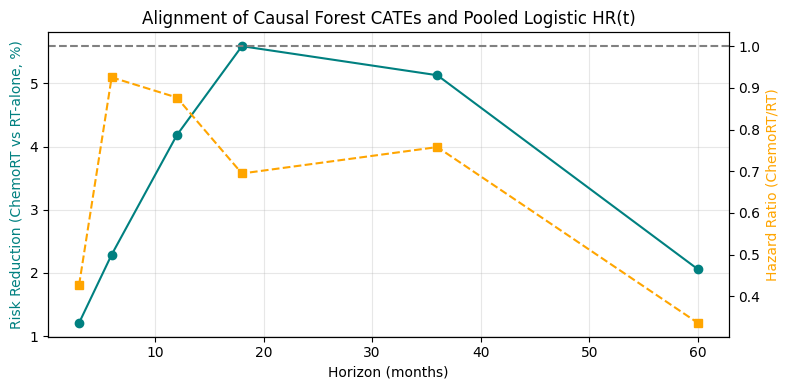

In [47]:
#Collect mean CATEs from forest
forest_summary = pd.DataFrame({
    'horizon_m': [3,6,12,18,36,60],
    'mean_cate': [-0.0121, -0.0229, -0.0418, -0.0559, -0.0513, -0.0206],
    'sd_cate': [0.034, 0.062, 0.130, 0.157, 0.156, 0.151]
})
forest_summary['survival_diff_%'] = -forest_summary['mean_cate'] * 100  # convert to % risk reduction

# Extract HR trend from pooled logistic
res_df['period_m'] = res_df['period_bin'].replace({
    '0-3': 3, '4-6': 6, '7-12': 12, '13-24': 18, '25-60': 36, '60+': 60
})
res_df = res_df.sort_values('period_m')

# Merge comparison
merged = pd.merge(forest_summary, res_df[['period_m','HR_approx']], left_on='horizon_m', right_on='period_m', how='left')

# Plot
fig, ax1 = plt.subplots(figsize=(8,4))
ax1.plot(merged['horizon_m'], merged['survival_diff_%'], 'o-', color='teal', label='Causal Forest (Risk Reduction, %)')
ax1.set_ylabel('Risk Reduction (ChemoRT vs RT-alone, %)', color='teal')

ax2 = ax1.twinx()
ax2.plot(merged['horizon_m'], merged['HR_approx'], 's--', color='orange', label='Pooled Logistic HR')
ax2.axhline(1.0, color='gray', linestyle='--')
ax2.set_ylabel('Hazard Ratio (ChemoRT/RT)', color='orange')

ax1.set_xlabel('Horizon (months)')
ax1.set_title('Alignment of Causal Forest CATEs and Pooled Logistic HR(t)')
ax1.grid(alpha=0.3)
fig.tight_layout()

plt.savefig('outputs/compare_pooled_vs_forest.png')
plt.show()

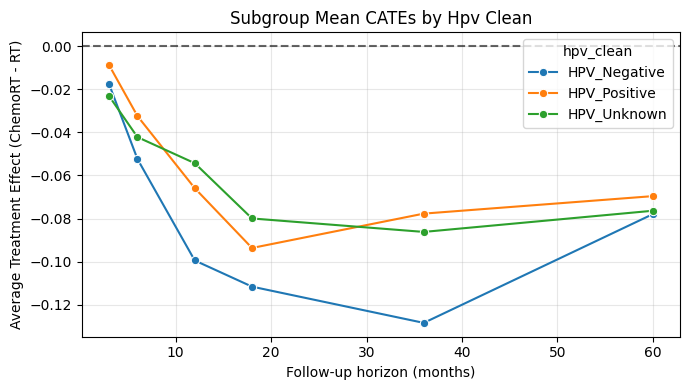

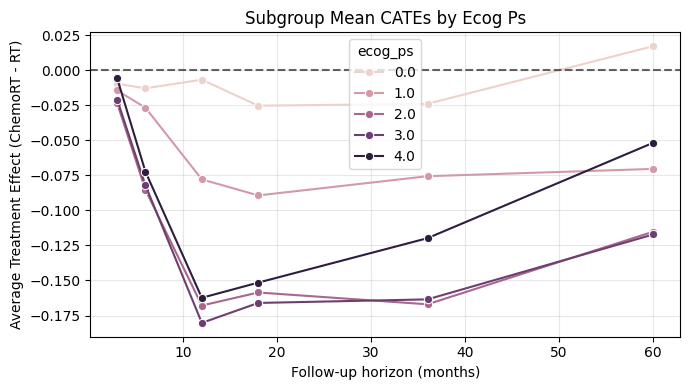

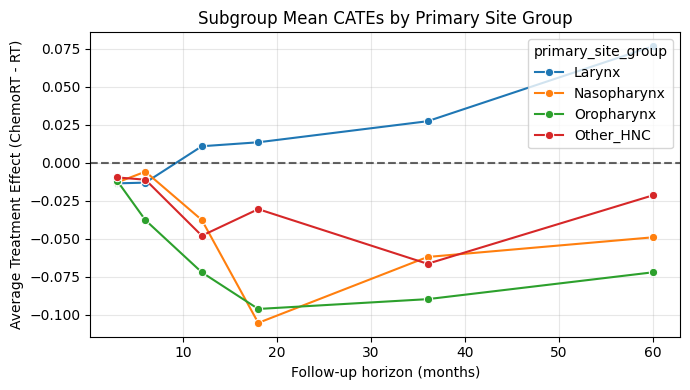

In [49]:
#Combine subgroup summaries again safely
group_vars = ['hpv_clean', 'ecog_ps', 'primary_site_group']
subgroup_summary = []

for g in group_vars:
    if g in train_patients.columns:
        # select only CATE columns
        cate_cols = [f'CATE_{h}m' for h in horizons if f'CATE_{h}m' in train_patients.columns]
        tmp = train_patients.groupby(g)[cate_cols].mean().reset_index()
        tmp['group'] = g
        subgroup_summary.append(tmp)

subgroup_summary = pd.concat(subgroup_summary, axis=0)

# --- Plot subgroup CATE trends ---
for g in group_vars:
    df_g = subgroup_summary[subgroup_summary['group'] == g].copy()

    # Keep only CATE columns for melting
    cate_cols = [c for c in df_g.columns if c.startswith('CATE_')]
    df_melt = df_g.melt(
        id_vars=[g, 'group'],
        value_vars=cate_cols,
        var_name='Horizon',
        value_name='Mean_CATE'
    )

    # Extract numeric horizon value (e.g. from 'CATE_12m' → 12)
    df_melt['Horizon'] = (
        df_melt['Horizon']
        .str.extract(r'CATE_(\d+)m')[0]
        .astype(int)
    )

    # Sort by horizon
    df_melt = df_melt.sort_values('Horizon')

    plt.figure(figsize=(7,4))
    sns.lineplot(data=df_melt, x='Horizon', y='Mean_CATE', hue=g, marker='o')
    plt.axhline(0, color='k', linestyle='--', alpha=0.6)
    plt.title(f"Subgroup Mean CATEs by {g.replace('_', ' ').title()}")
    plt.ylabel('Average Treatment Effect (ChemoRT - RT)')
    plt.xlabel('Follow-up horizon (months)')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"outputs/subgroup_CATE_{g}.png")
    plt.show()#

In [ ]:
# Save df with weights for further exploration
df[['patient_id','treatment','ps','sw','sw_trunc']].to_csv("outputs/ps_and_weights_final.csv", index=False)